In [14]:
import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import math
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import vfo.vfo as vfo

plt.switch_backend('Agg')  # 비대화형 백엔드

# 또는
%matplotlib inline

In [2]:
def plot_acceleration_with_min(csv_path, index=None, n_channels=6):
    """
    시간-변위 그래프를 그리고 선택된 센서(index)의 최소값과 최대값(hline) 및 수치를 표시하는 함수
    -------------------------------------------------------------------
    Parameters
    ----------
    csv_path : str
        CSV 파일 경로
    index : int or None
        특정 센서(열) 인덱스 (0부터 시작). None이면 모든 센서를 그림.
    n_channels : int, default=6
        변위 데이터 열 개수 (시간열 다음에 있는 센서 개수)
    """
    # ============================================================
    # 1️⃣ 데이터 불러오기
    # ============================================================
    df = pd.read_csv(csv_path)

    # ============================================================
    # 2️⃣ 시간열 + 변위 데이터 추출
    # ============================================================
    time = df.iloc[:, 0].values
    disp_data = df.iloc[:, 1+6:n_channels+1+6]  # 변위 데이터 (예: 7~12열)

    # ============================================================
    # 3️⃣ 특정 인덱스 선택
    # ============================================================
    if index is not None:
        if index < 0 or index >= disp_data.shape[1]:
            raise ValueError(f"index={index} is out of range (0 ~ {disp_data.shape[1]-1})")
        disp_data = disp_data.iloc[:, [index]]

    # ============================================================
    # 4️⃣ 그래프 시각화
    # ============================================================
    plt.figure(figsize=(12, 8))

    for col in disp_data.columns:
        y = disp_data[col].values
        min_val = y.min()
        max_val = y.max()
        min_time = time[y.argmin()]
        max_time = time[y.argmax()]

        # 변위 그래프
        plt.plot(time, y, lw=0.9, label=str(col))

        # 최소값 표시
        plt.axhline(min_val, color='red', linestyle='--', alpha=0.6)
        plt.text(
            time[-1]*0.98,
            min_val,
            f"{col} min: {min_val:.4f}",
            color='red',
            fontsize=12,
            ha='right', va='bottom'
        )

        # 최대값 표시
        plt.axhline(max_val, color='blue', linestyle='--', alpha=0.6)
        plt.text(
            time[-1]*0.98,
            max_val,
            f"{col} max: {max_val:.4f}",
            color='blue',
            fontsize=12,
            ha='right', va='bottom'
        )

    plt.xlabel("Time [sec]")
    plt.ylabel("Displacement")
    title_suffix = f" (Sensor {index})" if index is not None else " (All Sensors)"
    plt.title(f"Time–Displacement History with Min/Max Values{title_suffix}")
    plt.legend(loc="upper right", ncol=2)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ============================================================
    # 5️⃣ 최소값 / 최대값 요약 출력
    # ============================================================
    print("📊 최소값 및 최대값 요약")
    for col in disp_data.columns:
        y = disp_data[col].values
        print(f"{col:10s}: min = {y.min():.6f} at t = {time[y.argmin()]:.3f} sec")
        print(f"{'':10s}  max = {y.max():.6f} at t = {time[y.argmax()]:.3f} sec\n")


In [15]:
def _set_equal_aspect_3d(ax):
    xlim = np.array(ax.get_xlim3d())
    ylim = np.array(ax.get_ylim3d())
    zlim = np.array(ax.get_zlim3d())
    c = np.array([xlim.mean(), ylim.mean(), zlim.mean()])
    r = max(xlim.ptp(), ylim.ptp(), zlim.ptp()) / 2
    ax.set_xlim3d(c[0]-r, c[0]+r)
    ax.set_ylim3d(c[1]-r, c[1]+r)
    ax.set_zlim3d(c[2]-r, c[2]+r)

def snapshot_model(path=None, use_vfo=True, elev=20, azim=-60, dpi=200, lw=0.8, node_size=6):

    if use_vfo and (vfo is not None):
        # VFO가 matplotlib 위에서 그리므로 그냥 저장 가능
        vfo.plot_model()
        try:
            ax = plt.gca()
            ax.view_init(elev=elev, azim=azim)
        except Exception:
            pass
        if path:
            plt.savefig(path, dpi=dpi, bbox_inches="tight")
        plt.close()
        return

    # ── Fallback: 간단 와이어프레임 ─────────────────────────────
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 요소 선 그리기
    for et in ops.getEleTags():
        nds = ops.eleNodes(et)
        coords = np.array([ops.nodeCoord(n) for n in nds], dtype=float)
        # 선형/빔: 연속 선
        for k in range(len(coords)-1):
            ax.plot([coords[k,0], coords[k+1,0]],
                    [coords[k,1], coords[k+1,1]],
                    [coords[k,2], coords[k+1,2]],
                    linewidth=lw)
        # 쉘(삼각/사각)은 마지막-처음을 닫아줌
        if len(coords) in (3,4):
            ax.plot([coords[-1,0], coords[0,0]],
                    [coords[-1,1], coords[0,1]],
                    [coords[-1,2], coords[0,2]],
                    linewidth=lw)

    # 노드 산점
    all_nodes = ops.getNodeTags()
    if all_nodes:
        X = [ops.nodeCoord(n)[0] for n in all_nodes]
        Y = [ops.nodeCoord(n)[1] for n in all_nodes]
        Z = [ops.nodeCoord(n)[2] for n in all_nodes]
        ax.scatter(X, Y, Z, s=node_size)

    ax.view_init(elev=elev, azim=azim)
    _set_equal_aspect_3d(ax)
    ax.set_xlabel('X (mm)'); ax.set_ylabel('Y (mm)'); ax.set_zlabel('Z (mm)')

    if path:
        plt.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)


In [4]:
Bridge_width = 12.5 #m
Bridge_skew = 36 # angle

girder_number = 6
Left_Cantilever, Right_Cantilever = 1.05, 1.05
girder_spacing = [2.08]
gravity = 9.81
#
UF = np.array(700)
UT = np.array(170)
UFT = np.array(200)
WH = np.array(1200)
WT = np.array(220)
LFT = np.array(200)
LT = np.array(230)
LF = np.array(680)
girder_H = UT + UFT + WH + LFT + LT
girder_length  = 29600   #거더 길이 (mm)

#####################################################################################################################################
#강연선 프로파일
number_tendon = 4

area_t = 50.27*12
z_coef_list = np.array([1500, 1086, 700, 294])   # 긴장재 끝단에서 하부플랜지로부터의 이격거리 #1, #2, #3, #4 .... 이 순서
z_intercept_list = np.array([200, 80, 80, 80])   # 중앙부에서 하부플랜지와의 이격거리

y_coef_list = np.array([0, 0, 0, 0])   # 
y_intercept_list = np.array([0, 0, -150, 150])   # 

tendon_horizontal_length = girder_length/2 

#PS강연선
Ep = np.array(200000.0)                                    #ps 강연선 탄성계수  (N/mm^2)
Ec = np.array(28896.0)                                         #콘크리트 탄성계수   (N/mm^2)
Ap_N = np.array([50.27*12, 50.27*12, 50.27*12, 50.27*12])                              #ps 강연선 면적 환산계수 곱하지 않은 것  (mm^2)

#덕트
A_duct_N = np.array([50.27*12, 50.27*12, 50.27*12, 50.27*12])                               # - 덕트 면적    (mm^2)
y_duct_N = np.array([1850, 1920, 1920, 1920])                     #상단-하단평균거리 (2000-80=1920) ############################################################################

In [5]:
### 교량 및 부재 제원###
#####################################################################################################################################
####단면 계산을 위한 제원이라, Openseespy에서 단면을 그릴 때는 높이 또는 두께에 대한 재계산이 필요함 Ex: 복부 단면은 h3-h2-h4 = 884(1200-60-256)####
# 총 단면

b1 = UF                                        #상부플랜지    (mm)
b2 = (UF-WT)/2                                         #상부 헌치     (mm)  삼각형부분만
b3 = WT                                         #웨브          (mm)
b4 = (LF-WT)/2                                        #하부 헌치     (mm)  삼각형부분만
b5 = LF                                      #하부 플랜지   (mm)

h1 = UT                                       #상부플랜지    (mm)
h2 = UFT                                          #상부 헌치     (mm)
h3 = UFT + WH + LFT                                     #웨브          (mm)
h4 = LFT                                          #하부 헌치     (mm)
h5 = LT                                        #하부 플랜지   (mm)

Ag1 = b1*h1
Ag2 = b2*h2
Ag3 = b3*h3
Ag4 = b4*h4
Ag5 = b5*h5
Ag = Ag1+Ag2+Ag3+Ag4+Ag5                        #총 단면적

yg1 = h1/2
yg2 = h1+h2/3
yg3 = h1+h3/2
yg4 = h1+h3-h4/3
yg5 = h1+h3+h5/2

Qg1 = Ag1*yg1
Qg2 = Ag2*yg2
Qg3 = Ag3*yg3
Qg4 = Ag4*yg4
Qg5 = Ag5*yg5
Qg = Qg1+Qg2+Qg3+Qg4+Qg5                       #총 단면의 단면1차모멘트

yt1 = Qg/Ag                                    #상면에서 총 단면의 중심축까지의 거리

yn_g1 = np.abs(yt1-yg1)                           #상부 플랜지 사각형의 도심에서 중심축까지의 거리
yn_g2 = np.abs(yt1-yg2)                           #상부 헌치 삼각형의 도심에서 중심축까지의 거리
yn_g3 = np.abs(yt1-yg3)                           #웨브 사각형의 도심에서 중심축까지의 거리
yn_g4 = np.abs(yt1-yg4)                           #하부 헌치 삼각형의 도심에서 중심축까지의 거리
yn_g5 = np.abs(yt1-yg5)                           #하부 플랜지 사각형의 도심에서 중심축까지의 거리

Ay2g1 = Ag1*yn_g1**2
Ay2g2 = Ag2*yn_g2**2
Ay2g3 = Ag3*yn_g3**2
Ay2g4 = Ag4*yn_g4**2
Ay2g5 = Ag5*yn_g5**2
Ay2_g_n_g = Ay2g1+Ay2g2+Ay2g3+Ay2g4+Ay2g5      #총 단면의 각 단면적 * 각 단면 도형의 도심에서 중심축까지 거리^2

Io_g1 = b1/12*h1*h1*h1
Io_g2 = b2/36*2*h2*h2*h2
Io_g3 = b3/12*h3 * h3 * h3
Io_g4 = b4/36*2*h4*h4*h4
Io_g5 = b5/12*h5*h5*h5
Io_g =  Io_g1 + Io_g2 + Io_g3 + Io_g4 + Io_g5             #각 단면 도형2 중심축에서의 단면2차모멘트

Ix_g = Io_g+Ay2_g_n_g                           #총 단면 단면2차모멘트

#####################################################################################################################################

Q_duct_N = []
for i in range(len(A_duct_N)):
    Q_duct_N.append(A_duct_N[i] * y_duct_N[i])
Q_duct_N = np.array(Q_duct_N)
Q_duct = np.sum(np.array(Q_duct_N))                           #쉬스관 단면1차모멘트
A_duct = np.sum(np.array(A_duct_N))                          #쉬스관 총 넓이
y_duct = Q_duct/A_duct                           #상면에서 쉬스관 모든 도형의 도심점까지의 거리

#####################################################################################################################################
#콘크리트 순 단면
A_net = Ag-A_duct                                #콘크리트 순면적 ( 왜 더하는가?) 
Q_net = Qg-Q_duct                                #콘크리트 순단면 단면1차모멘트
yt2 = Q_net/A_net                                #상면에서부터 콘크리트 순단면의 도심까지 거리

y_net_P = np.abs(yt2-yt1)                           #총 단면의 도심과 콘크리트 순단면의 도심사이 거리

y_duct_P_N = []
for i in range(len(y_duct_N)):
    y_duct_P_N.append(abs(yt2 - y_duct_N[i]))    #쉬스관 도형의 도심과 콘크리트 순단면의 도심사이 거리
y_duct_P_N = np.array(y_duct_P_N)
Ay2_g_net_P = Ag*y_net_P**2                      #총 단면적 * 총 단면의 도심과 콘크리트 순단면의 도심사이 거리^2

Ay2_duct_N_duct_P_N = []
for i in range(len(y_duct_P_N)):
    Ay2_duct_N_duct_P_N.append(A_duct_N[i]*y_duct_P_N[i]**2)
Ay2_duct_duct_P = np.sum(np.array(Ay2_duct_N_duct_P_N))                           #쉬스관의 각 단면적 * 쉬스관 도형의 각 도심과 콘크리트 순단면의 도심사이 거리^2

Ay2_net = Ay2_g_net_P+Ay2_duct_duct_P                          #총 단면적 * 총 단면의 도심과 콘크리트 순단면의 도심사이 거리^2
                                                               #   - 쉬스관의 각 단면적 * 각 단면 도형의 도심에서 중심축까지 거리^2
Io_net = Ix_g
Ix_net = Io_net+Ay2_net                            #순 단면 단면2차모멘트

#####################################################################################################################################

#####################################################################################################################################
Np = Ep/Ec

Ap = np.sum(np.array(Ap_N))
yp_N = y_duct_N

Qp_N = []
for i in range(len(Ap_N)):
    Qp_N.append(Ap_N[i] * yp_N[i])

Qp = np.sum(np.array(Qp_N))                             #PS강연선 총 단면1차모멘트
yp = Qp/Ap
#####################################################################################################################################
#PS강연선 환산단면
At_p = Ap*Np
At = A_net + At_p
Qt = Q_net+At_p*yp
yt3 = Qt/At

yt_P_N = np.array([abs(yt3 - yp_N[i]) for i in range(len(yp_N))])

Ay2_t_t_P_N = np.array([Ap_N[i]*Np*yt_P_N[i]**2 for i in range(len(yt_P_N))])

y_net_PP = np.abs(yt3-yt2)

Io_t = Ix_net
Ix_t = Io_t + np.sum(np.array(Ay2_t_t_P_N)) + A_net*y_net_PP**2

#####################################################################################################################################
A_t = np.array(At)
B_t = np.array(Qt)
I_n = np.array(Ix_t)

I_n, yt3   ##yt3은 상면에서 중립축까지 거리

(array(3.63847178e+11), np.float64(1037.485027702135))

In [6]:
class Analysis():
    def __init__(self, length,  width, nums_girder, skew):
        # Adopted units: N and mm
        self.kilo = 1e3
        self.milli = 1e-3
        self.N = 1
        self.mm = 1
        self.m = 1000*self.mm
        self.m3 = self.m * self.m * self.m
        self.mm2 = self.mm ** 2
        self.mm3 = self.mm ** 3
        self.mm4 = self.mm ** 4
        self.kN = self.kilo * self.N
        self.MPa = self.N / self.mm2
        self.GPa = self.kilo * self.MPa
        self.transftype = "Linear"
        self.nums_girder = nums_girder
        self.width = width * self.m
        self.skew = skew
        self.L = length * self.m

    def girder(self, girder_number, Ec, Pe,  spacing):
        name = 'girder' + str(girder_number) + '_centroid' # 교축 방향 라인 별로 이름 정의.
        ####################  Concrete dimension   ########################################
        L = self.L  # girder design length (mm)
        division = int(L /self.m * 5)     ######## 길이 기준(Element)
        imax = division + 1   # element + 1 (노드 기준)

        x_loc = -1 * spacing * np.tan(math.radians(self.skew)) * self.m          #교축방향
        y_loc = spacing * self.m                                                 #교축직각
        centroid = yt3 #  거더 상연부터 도심까지 거리
                            #z1             y1         z2             y2       z3                 y3         z4              y4
        section1 = [    int(-h1),    int(-b1/2),   int(0),        int(-b1/2), int(0),        int(b1/2), int(-h1),        int(b1/2) ]           #100(h1), 1000(b1)
        section2 = [  int(-h1-h2),   int(-b3/2),  int(-h1),      int(-b1/2), int(-h1),     int(b1/2),  int(-h1-h2),   int(b3/2) ]           #100, (200, 400)
        section3 = [ int(-h1-h3+h4), int(-b3/2), int(-h1-h2),    int(-b3/2), int(-h1-h2),   int(b3/2),  int(-h1-h3+h4),  int(b3/2) ]         #600, 200
        section4 = [   int(-h1-h3),  int(-b5/2), int(-h1-h3+h4), int(-b3/2), int(-h1-h3+h4), int(b3/2), int(-h1-h3),    int(b5/2)]        #200, (200, 450)
        section5 = [ int(-h1-h3-h5), int(-b5/2),   int(-h1-h3),   int(-b5/2), int(-h1-h3),   int(b5/2),int(-h1-h3-h5),    int(b5/2)]        #150, 450
        sections = [section1, section2, section3, section4, section5]
        Acol = Ag * self.mm2
        ####################  Concrete MATERIAL   ########################################
        IDconcU = 1000 + girder_number       # unconfined cover concrete
        ops.uniaxialMaterial("Elastic", IDconcU , Ec)         # concrete
        
        #################### Tendon Material     ########################################
        IDstrand = 10 +  girder_number               # strand
        IDstrand_initial =  100 + girder_number      # strand
        Pe = Pe * self.MPa
        Fpy = 1364 * self.MPa                # strand yield stress
        Es = Ep * self.MPa
        Bps = 0.0236               # strain-hardening ratio
        ops.uniaxialMaterial("Steel01", IDstrand, Fpy, Es, Bps)             # Tendon
        ops.uniaxialMaterial("InitStressMaterial", IDstrand_initial, IDstrand, Pe)                 # Initial Stress for PS

        ####################   Section-property  ########################################
        J = ((b1*h1**3) + (b3 * h3**3) +  (b5 * h5**3))/3
        v = 0.17
        G = Ec / 2 / (1+v)
        GJ = G * J

        transfArgs=[0,0,1]  #local z방향 벡터 -- 로컬 z축이 전역 y축과 일치 
        ops.geomTransf(self.transftype, 1000 + girder_number, *transfArgs)  # 좌표변환을 정의함. 
       ####################   Node   ########################################
    
        mass_ratio = [0.0, 0.0, 1.0]  
        rho = 2.5e-9 # N·s²/mm⁴ 질량밀도 단위로 작성  # kg/mm³ → 2.5e-6  (콘크리트 밀도는 보통 2500 kg/m^3) 1 kg = 0.001 N·s²/mm
        muBeam = rho * Acol #N·s²/mm2
        nodes={}
        
        mass_before = []
        mass_after = []
        
        for j in range(0, imax): 
            ops.node(int(1000 * girder_number+j+1), x_loc+L/division*j,  y_loc, -centroid)
            mass_before.append(rho * Acol * L/division / 2)
            mass_after.append(rho * Acol * L/division / 2)
            
        mass_before[-1] = 0
        mass_after[0] = 0
        mass_all = np.array(mass_before) + np.array(mass_after)
        mass_all = mass_all.tolist()
        
        for j in range(0, imax):
            ops.mass(int(1000 * girder_number+j+1),0,  0, mass_all[j])  # ops.mass는 kg단위가 아닌, N*s^2/mm 단위로 넣어줘야함. 따라서. kg -> 0.001을 곱해줌) 
        
       # 기존
        # nodes[name] = np.c_[np.asarray(ops.getNodeTags())[np.asarray(ops.getNodeTags())>=1000*girder_number],
        #           np.asarray([(ops.nodeCoord(int(t))) for t in np.asarray(ops.getNodeTags())[np.asarray(ops.getNodeTags())>=1000*girder_number]])]

        # 수정: 거더별 노드 태그 하한/상한 범위 필터
        tags = np.asarray(ops.getNodeTags(), dtype=int)

        # 이미 위에서 계산된 imax = division + 1 사용
        lower = 1000 * girder_number + 1
        upper = 1000 * girder_number + imax  # 포함 상한

        sel = (tags >= lower) & (tags <= upper)
        gid_tags = np.sort(tags[sel])
        coords = np.array([ops.nodeCoord(int(t)) for t in gid_tags], dtype=float)
        nodes[name] = np.column_stack([gid_tags, coords])  # shape: (N, 1+3)

        nfY1, nfZ1 = 2,5
        nfY2, nfZ2 = 1,2
        nfY3, nfZ3 = 3,1
        nfY4, nfZ4 = 2,3
        nfY5, nfZ5 = 1,3

        #실제 무게 반영해야함(모델로부터 오면 좋을 듯)
        class Tendon():
            def __init__(self):
                pass
            def tendon_profile_vertical(self, x ,coeffiecient, intercept):
                x = np.array(x)
                z = coeffiecient* x **2 +  intercept
                return z
            def tendon_profile_horizontal(self, x ,coeffiecient, intercept):
                x = np.array(x)
                z = coeffiecient* x **2 +  intercept
                return z

        quads = ['quad1', 'quad2', 'quad3', 'quad4', 'quad5']  # 단면 수 fiber
        a_coef = (z_coef_list-z_intercept_list) / tendon_horizontal_length / tendon_horizontal_length
        b_coef = (y_coef_list-y_intercept_list) / tendon_horizontal_length / tendon_horizontal_length
        
        for i in range(0, imax):
            a = L * i / (imax - 1)
            ops.section('Fiber', int(nodes[name][i][0]), '-GJ', GJ)

            sections1 = [
            (section1, nfY1, nfZ1, 'quad1'),
            (section2, nfY2, nfZ2, 'quad2'),
            (section3, nfY3, nfZ3, 'quad3'),
            (section4, nfY4, nfZ4, 'quad4'),
            (section5, nfY5, nfZ5, 'quad5')]

            for sec, nfY, nfZ, quad in sections1:
                ops.patch('quad', IDconcU, nfY, nfZ, *sec)
                for k in np.arange(1, 1+number_tendon).tolist():
                    z = Tendon().tendon_profile_vertical(a - L / 2 , a_coef[k-1], z_intercept_list[k-1]) - girder_H
                    if sec[0] < z < sec[2]: #patch내에 있는지 확인( sec[0],[2]는 z값임)
                        y = Tendon().tendon_profile_horizontal(a - L / 2, b_coef[k-1], y_intercept_list[k-1])
                        ops.layer('straight', IDstrand_initial, 1, Ap_N[k-1], z, y, z, y)
                    else:
                        y = Tendon().tendon_profile_horizontal(a - L / 2, b_coef[k-1], y_intercept_list[k-1])
                        ops.layer('straight', IDstrand_initial, 1, 0, z, y, z, y)

        beam_el={}
        beam_el[name]=np.array([],dtype=int)
        numIntgrPts = 5
        
        for i in range(0, division, 1):
            ops.beamIntegration('Legendre', int(nodes[name][i][0]), int(nodes[name][i][0]), numIntgrPts)  # 단면을 부여하고 요소 사이를 어떻게 적분할지를 결정하는 부분, 현재 5개의 적분점에 전부 동일한 단면 부여
            if i < imax+1:
                ops.element('dispBeamColumn', int(nodes[name][i][0]), int(nodes[name][i][0]), int(nodes[name][i+1][0]), 
                    1000+girder_number, int(nodes[name][i][0])) #노드번호랑 요소 번호랑 동일 요소번호 = 노드-1 
            beam_el[name]=np.append(beam_el[name], int(nodes[name][i][0]))
            
        return nodes, beam_el

    def pavement(self, pave_number, tSlab, Ec_slab, bridge_width_spacings, slab_thickness_spacing_cumsum):
        name = 'deck'
        L = self.L  # girder design length
        #bridge_width_spacings = np.arange(0, 12.5, 1, dtype = np.float32)-ex) (0,1,2,3,4,5,6,7,8,9,10,11,12)
        slab_spacings = np.unique(np.round(np.sort(np.hstack([bridge_width_spacings, 
            slab_thickness_spacing_cumsum])), 3))
        #array([ 0.  ,  1.  ,  1.25,  2.  ,  3.  ,  3.25,  4.  ,  5.  ,  5.25, 6.  ,  7.  ,  7.25,  8.  ,  9.  ,  9.25, 10.  , 11.  , 11.25, 12., 12.5 ])
        slab_found_indices = np.where(np.isin(slab_spacings, slab_thickness_spacing_cumsum))[0]

        # cumsum이 존재하는 배열을 추출 -> [ 0,  2,  5,  8, 11, 14, 17, 19] -거더갯수+2(캔틸레버) 
        division = int(L / self.m * 5)
        imax = division + 1   # element + 1  --149
        spacing = slab_spacings * 1000
        
        name_list = []
        for i in range(len(spacing)):
            name_list.append('pavement' + str(i))

        nodes = {}
        for k in range(len(slab_found_indices)-1):
            if k != len(slab_found_indices)-2:
                slicing_list = np.arange(slab_found_indices[k], slab_found_indices[k+1]) #np.arrange(0,4) = [0,1,2,3] -> 슬라이싱 
                spacing_list = slab_spacings[slicing_list]
            else:
                slicing_list = np.arange(slab_found_indices[k], slab_found_indices[k+1]+1)
                spacing_list = slab_spacings[slicing_list]
                
            for i in range(len(spacing_list)):
                for j in range(division+1):
                    ops.node(int(pave_number * 100000 + 1000*slicing_list[i]+j+1),                     
                             float(-1 *  1000*spacing_list[i] * np.tan(math.radians(self.skew))+L/division*j),                
                             1000*float(spacing_list[i]),
                             tSlab[0]/2 + 220 ) # 바닥판 두께를 더해줘야함.
                    
                    # 아래는 opensees에서 정의된 node를 딕셔너리 변수에 할당
                nodes[name_list[slicing_list[i]]]=np.c_[np.asarray(ops.getNodeTags())[np.asarray(ops.getNodeTags())>= pave_number * 100000 + 1000*slicing_list[i]],
                                        np.asarray([(ops.nodeCoord(int(t))) for t in np.asarray(ops.getNodeTags())
                                                 [np.asarray(ops.getNodeTags())>= pave_number * 100000 + 1000*slicing_list[i]]])]

        v = 0.1
        shell_el={}
        shell_el[name]=np.array([], dtype=int)

        #실제 무게 반영해야함(모델로부터 오면 좋을 듯)
        rho = 2.0e-9  # N·s²/mm^4
        tSlab = np.array(tSlab)/2 + np.array(tSlab)/2
        for k in range(len(slab_found_indices)-1):  # 두께 변화구간 
            slabSection = pave_number * 100 + 1 + k
            tSlabx = tSlab[0]
            Ec_slabx = Ec_slab[0]
            ops.section('ElasticMembranePlateSection', slabSection, Ec_slabx, v, tSlabx, 0) # 0대신 rho를 넣으면 질량이 중복으로 들어감. 해당 단면요소는 자동으로 질량을 노드에 부여하는 기능을 가짐. 현재 내코드로 작성 

            slicing_list = np.arange(slab_found_indices[k], slab_found_indices[k+1])
            spacing_list = slab_spacings[slicing_list]
            for i in range(0, len(spacing_list)):
                for j in range(1, imax, 1):
                    #element('ShellMITC4', eleTag, *eleNodes, secTag)
                    #a list of four element nodes in counter-clockwise order
                    ops.element('ShellNLDKGQ', int(nodes[name_list[slicing_list[i]]][j-1,0]),
                               *(np.asarray([nodes[name_list[slicing_list[i]]][j-1][0],
                                             nodes[name_list[slicing_list[i]]][j][0],
                                             nodes[name_list[slicing_list[i]+1]][j][0],
                                             nodes[name_list[slicing_list[i]+1]][j-1][0]], dtype=(int))).tolist(), slabSection)
                    #shell_el[name] = np.append(shell_el[name], int(nodes[name_list[i]][j-1,0]))
                    
        volume_list = []  # shell element별 부피 구하기
        for k in range(len(slab_found_indices)-1):
            tSlabx = tSlab[0]
            slicing_list = np.arange(slab_found_indices[k], slab_found_indices[k+1])
            spacing_list = slab_spacings[slicing_list]
            for i in range(0, len(spacing_list)):
                for j in range(1, imax, 1):
                    volume_list.append(tSlabx * (nodes[name_list[slicing_list[i]]][j][1] - nodes[name_list[slicing_list[i]]][j-1][1])*
                                             (nodes[name_list[slicing_list[i]+1]][j][2] - nodes[name_list[slicing_list[i]]][j][2]))              
        volume_list1 = np.array(volume_list).reshape(len(spacing)-1, -1) * rho
        
        volume_node_list = []
        for i in range(0, len(volume_list1)):
            a = np.insert(np.array(volume_list1[i]), 0, 0) / 4
            b = np.insert(np.array(volume_list1[i]), len(volume_list1[i]), 0) / 4
            volume_node_list.append(a + b)  
        volume_node_list = np.array(volume_node_list)
        
        volume_node_list1 = []
        for i in range(0, len(volume_node_list.T)):
            a = np.insert(np.array(volume_node_list.T[i]), 0, 0)
            b = np.insert(np.array(volume_node_list.T[i]), len(volume_node_list.T[i]), 0)
            volume_node_list1.append(a+b)
        volume_node_list1 =  np.array(volume_node_list1).T
        for i in range(len(volume_node_list1)):
            for j in range(len(volume_node_list1[i])):
                ops.mass(int(nodes['pavement'+str(i)][j][0]), 0, 0, volume_node_list1[i][j])

        return nodes
    
    def deck(self, deck_number, tSlab, Ec_slab, bridge_width_spacings, slab_thickness_spacing_cumsum):
        name = 'deck'
        L = self.L  # girder design length
        #bridge_width_spacings = np.arange(0, 12.5, 1, dtype = np.float32)-ex) (0,1,2,3,4,5,6,7,8,9,10,11,12)
        slab_spacings = np.unique(np.round(np.sort(np.hstack([bridge_width_spacings, slab_thickness_spacing_cumsum])), 3))
        #array([ 0.  ,  1.  ,  1.25,  2.  ,  3.  ,  3.25,  4.  ,  5.  ,  5.25, 6.  ,  7.  ,  7.25,  8.  ,  9.  ,  9.25, 10.  , 11.  , 11.25, 12., 12.5 ])
        slab_found_indices = np.where(np.isin(slab_spacings, slab_thickness_spacing_cumsum))[0]
        # cumsum이 존재하는 배열을 추출 -> [ 0,  2,  5,  8, 11, 14, 17, 19] -거더갯수+2(캔틸레버) 
        division = int(L / self.m * 5)
        imax = division + 1   # element + 1  --149
        spacing = slab_spacings * 1000
        
        name_list = []
        for i in range(len(spacing)):
            name_list.append('slab' + str(i))

        nodes = {}
        for k in range(len(slab_found_indices)-1):
            if k != len(slab_found_indices)-2:
                slicing_list = np.arange(slab_found_indices[k], slab_found_indices[k+1]) #np.arrange(0,4) = [0,1,2,3] -> 슬라이싱 
                spacing_list = slab_spacings[slicing_list]
            else:
                slicing_list = np.arange(slab_found_indices[k], slab_found_indices[k+1]+1)
                spacing_list = slab_spacings[slicing_list]
                
            for i in range(len(spacing_list)):
                for j in range(division+1):
                    ops.node(int(deck_number * 100000 + 1000*slicing_list[i]+j+1),                     
                             float(-1 *  1000*spacing_list[i] * np.tan(math.radians(self.skew))+L/division*j),                
                             1000*float(spacing_list[i]),
                             tSlab[k]/2)
                    
                    # 아래는 opensees에서 정의된 node를 딕셔너리 변수에 할당
                nodes[name_list[slicing_list[i]]]=np.c_[np.asarray(ops.getNodeTags())[np.asarray(ops.getNodeTags())>= deck_number * 100000 + 1000*slicing_list[i]],
                                        np.asarray([(ops.nodeCoord(int(t))) for t in np.asarray(ops.getNodeTags())
                                                 [np.asarray(ops.getNodeTags())>= deck_number * 100000 + 1000*slicing_list[i]]])]

        v = 0.17
        shell_el={}
        shell_el[name]=np.array([], dtype=int)

        #실제 무게 반영해야함(모델로부터 오면 좋을 듯)
        rho = 2.5e-9  # N·s²/mm^4
        tSlab = np.array(tSlab[:-1])/2 + np.array(tSlab[1:])/2
        for k in range(len(slab_found_indices)-1):  # 두께 변화구간 
            slabSection = deck_number * 100 + 1 + k
            tSlabx = tSlab[k]
            Ec_slabx = Ec_slab[k]
            ops.section('ElasticMembranePlateSection', slabSection, Ec_slabx, v, tSlabx, 0) # 0대신 rho를 넣으면 질량이 중복으로 들어감. 해당 단면요소는 자동으로 질량을 노드에 부여하는 기능을 가짐. 현재 내코드로 작성 

            slicing_list = np.arange(slab_found_indices[k], slab_found_indices[k+1])
            spacing_list = slab_spacings[slicing_list]
            for i in range(0, len(spacing_list)):
                for j in range(1, imax, 1):
                    #element('ShellMITC4', eleTag, *eleNodes, secTag)
                    #a list of four element nodes in counter-clockwise order
                    ops.element('ShellNLDKGQ', int(nodes[name_list[slicing_list[i]]][j-1,0]),
                               *(np.asarray([nodes[name_list[slicing_list[i]]][j-1][0],
                                             nodes[name_list[slicing_list[i]]][j][0],
                                             nodes[name_list[slicing_list[i]+1]][j][0],
                                             nodes[name_list[slicing_list[i]+1]][j-1][0]], dtype=(int))).tolist(), slabSection)
                    #shell_el[name] = np.append(shell_el[name], int(nodes[name_list[i]][j-1,0]))
                    
        volume_list = []  # shell element별 부피 구하기
        for k in range(len(slab_found_indices)-1):
            tSlabx = tSlab[k]
            slicing_list = np.arange(slab_found_indices[k], slab_found_indices[k+1])
            spacing_list = slab_spacings[slicing_list]
            for i in range(0, len(spacing_list)):
                for j in range(1, imax, 1):
                    volume_list.append(tSlabx * (nodes[name_list[slicing_list[i]]][j][1] - nodes[name_list[slicing_list[i]]][j-1][1])*
                                             (nodes[name_list[slicing_list[i]+1]][j][2] - nodes[name_list[slicing_list[i]]][j][2]))              
        volume_list1 = np.array(volume_list).reshape(len(spacing)-1, -1) * rho
        
        volume_node_list = []
        for i in range(0, len(volume_list1)):
            a = np.insert(np.array(volume_list1[i]), 0, 0) / 4
            b = np.insert(np.array(volume_list1[i]), len(volume_list1[i]), 0) / 4
            volume_node_list.append(a + b)  
        volume_node_list = np.array(volume_node_list)
        
        volume_node_list1 = []
        for i in range(0, len(volume_node_list.T)):
            a = np.insert(np.array(volume_node_list.T[i]), 0, 0)
            b = np.insert(np.array(volume_node_list.T[i]), len(volume_node_list.T[i]), 0)
            volume_node_list1.append(a+b)
        volume_node_list1 =  np.array(volume_node_list1).T
        for i in range(len(volume_node_list1)):
            for j in range(len(volume_node_list1[i])):
                ops.mass(int(nodes['slab'+str(i)][j][0]), 0, 0, volume_node_list1[i][j])

        return nodes
    
    def barrier(self, number,  spacing, Ec, deck_thickness, pave_thick,  height, width):
        L = self.L  # span
        division = int(L / self.m * 5)
        imax = division + 1   # element + 1

        #plate model 기준... 메쉬 크기를 어떻게 하는게 좋을까??
        y_loc = spacing * self.m
        name = 'guard' + str(number)
        deck_thickness = np.array(deck_thickness)
        pave_thick = np.array(pave_thick[0]);
        height =  height * self.m
        width = width * self.m
        width1 = np.abs(width) 
        A_guard = width1 * height
        x_loc = -(y_loc + width/2) * np.tan(math.radians(self.skew))

        nodes={}
        rho = 2.5e-9 # N·s²/mm^4
        mass_before = []
        mass_after = []
        
        for j in range(imax):
            ops.node(1000000 + 10000*number+j+1, x_loc+L/division*j, y_loc + width/2, height / 2 + deck_thickness + pave_thick)
            mass_before.append(rho * A_guard * L/division / 2)
            mass_after.append(rho * A_guard * L/division / 2)
                     
        mass_before[-1] = 0
        mass_after[0] = 0
        mass_all = np.array(mass_before) + np.array(mass_after)
        mass_all = mass_all.tolist()
        
        for j in range(0, imax):
            ops.mass(int(1000000 + 10000*number+j+1),0,  0, mass_all[j])

        # 아래는 opensees에서 정의된 node를 딕셔너리 변수에 할당
        nodes[name]=np.c_[np.asarray(ops.getNodeTags())[np.asarray(ops.getNodeTags())>=1000000 + 10000*number],
            np.asarray([(ops.nodeCoord(int(t))) for t in np.asarray(ops.getNodeTags())[np.asarray(ops.getNodeTags())>=1000000 + 10000*number]])]

        transfArgs = [0,0,1]
        ops.geomTransf(self.transftype,10 + number, *transfArgs)
        numIntgrPts = 5
        beam_el = {}
        beam_el[name]=np.array([],dtype=int)

        A_guard = width1 * height
        Iz_guard = width1 * height * height* height / 12
        Iy_guard =  height * width1 * width1 * width1 / 12
        J_guard = Iz_guard+Iy_guard
        v = 0.2
        guardSection = 20 + number
        fc = -24 * self.MPa                    #fck가 34 MPa
        #Ec = 8500*(-fc)**(1/3)
        G = Ec / 2 / (1+v)
        ops.section('Elastic', guardSection, Ec, A_guard, Iz_guard, Iy_guard, G, J_guard)
         #실제 무게 반영해야함(모델로부터 오면 좋을 듯)
 
        for i in range(2, imax+1, 1):
            ops.beamIntegration('Legendre', int(nodes[name][i-2][0]), guardSection, numIntgrPts)
            ops.element('dispBeamColumn', int(nodes[name][i-2][0]), int(nodes[name][i-2][0]), int(nodes[name][i-1][0]),
                        10 + number, int(nodes[name][i-2][0]))
            beam_el[name]=np.append(beam_el[name],int(nodes[name][i-2][0]))

        return nodes, beam_el

    def diaphragm(self, bridge_number,  number, node, Ec, nums_girder):
        
        nodes= np.array([])

        length = girder_spacing[0] / math.cos(math.radians(self.skew)) * self.m # 가로보 길이 
        height = 1.795 * self.m
        thickness = 0.30 * self.m
        theta = math.radians(self.skew)
        
        transfArgs= [0, -math.sin(theta), math.cos(theta)]
        numIntgrPts = 5

        A_diaphragm = height * thickness      
        Iz_diaphragm = thickness * height *height* height  / 12
        Iy_diaphragm =  height * thickness * thickness * thickness / 12
        J_diaphragm = Iz_diaphragm + Iy_diaphragm
        v = 0.17

        fc = -24 * self.MPa
        rho = 2.5e-9
        
        mass_before = []
        mass_after = []
        for i in range(1, 1 + nums_girder):
            ops.node(bridge_number * 100 + 10 *number + i, ops.nodeCoord(node[i-1])[0], ops.nodeCoord(node[i-1])[1], -height/2)
            nodes = np.append(nodes, int(bridge_number * 100 + 10 * number + i))
            mass_before.append(rho * A_diaphragm * length / 2)
            mass_after.append(rho * A_diaphragm * length / 2)
            
        mass_before[-1] = 0
        mass_after[0] = 0
        mass_all = np.array(mass_before) + np.array(mass_after)
        mass_all = mass_all.tolist()   
        
        for i in range(len(nodes)):
            ops.mass(int(nodes[i].tolist()), 0,  0, mass_all[i])

        for i in range(1, nums_girder, 1):
            name = 'diaphragm' + str(bridge_number * 100 + 10 *number + i)
            ops.geomTransf(self.transftype, bridge_number * 100 + 10 *number + i, *transfArgs)
            
            beam_el = {}
            beam_el[name]=np.array([],dtype=int)
            Ec1 =  Ec[i-1]
            G = Ec1 / 2 / (1+v)
            diaphragm_Section = bridge_number * 100 + 10 * number + i
            ops.section('Elastic', diaphragm_Section, Ec1, A_diaphragm, Iz_diaphragm, Iy_diaphragm, G, J_diaphragm)
            ops.beamIntegration('Legendre', bridge_number * 100 + 10 *number + i, diaphragm_Section, numIntgrPts)
            ops.element('dispBeamColumn', bridge_number * 100 + 10 *number + i, bridge_number * 100 + 10 *number + i, bridge_number * 100 + 10 *number + i + 1, bridge_number * 100 + 10 *number + i, bridge_number * 100 + 10 *number + i)
            beam_el[name]=np.append(beam_el[name], bridge_number * 100 + 10 *number + i)
            
        return nodes

    def spring(self, spring_number, node, girder_height, *stiffness):
        stiffness = np.array(stiffness)[0] # 첫번째 행만 꺼냄 (하나의 받침정보들 )
        h = girder_height * self.mm            # girder height
        IDhspring_axis = spring_number * 100 - spring_number
        IDhspring_transverse = spring_number * 1000 - spring_number
        IDvspring = spring_number * 10000

        ID_spring_rot1 = spring_number * 100000 + spring_number
        ID_spring_rot2 = spring_number * 1000000 + spring_number
        ID_spring_rot3 = spring_number * 10000000 + spring_number

        kh_axis = stiffness[0] * self.kN / self.m    # 7549
        kh_transverse = stiffness[1] * self.kN / self.m    ##7549
        kv = stiffness[2]  * self.kN / self.m       # 659700

        k_rot1 = 0 * self.kN / self.m      ##비틀림
        k_rot2 = 0 * self.kN / self.m        ##수직방향 회전
        k_rot3 = 0 * self.kN / self.m     # 횡방향 회전

        ops.uniaxialMaterial("Elastic", IDvspring, kv)         # spring (z)
        ops.uniaxialMaterial("Elastic", IDhspring_axis, kh_axis)         # spring (x)
        ops.uniaxialMaterial("Elastic", IDhspring_transverse, kh_transverse)         # spring (y)

        ops.uniaxialMaterial("Elastic", ID_spring_rot1, k_rot1)         # spring
        ops.uniaxialMaterial("Elastic", ID_spring_rot2, k_rot2)         # spring
        ops.uniaxialMaterial("Elastic", ID_spring_rot3, k_rot3)         # spring

        support_node = 10000000 + spring_number
        spring_node = 100000000 + spring_number

        ####아래는 지점를 위한 노드
        ops.node(support_node,
                ops.nodeCoord(node)[0], ops.nodeCoord(node)[1], -int(h))
        ####아래는 지점 스프링 요소를 위한 노드
        ops.node(spring_node,
                ops.nodeCoord(node)[0], ops.nodeCoord(node)[1], -int(h))

        ops.element('zeroLength', support_node ,         spring_node, support_node, '-mat', IDhspring_axis,        '-dir', 1)     ## 교축임(가정)
        ops.element('zeroLength', support_node + 100,    spring_node, support_node, '-mat', IDhspring_transverse,  '-dir', 2)  # 'dir'에서 1이 교축인지 2가 교축인지 찾아야함(2가 없어도 해석이 돌아감)
        ops.element('zeroLength', support_node + 200,    spring_node, support_node, '-mat', IDvspring,             '-dir', 3)   #수직
        ops.element('zeroLength', support_node + 300,    spring_node, support_node, '-mat', ID_spring_rot1,        '-dir', 4)   #회전
        ops.element('zeroLength', support_node + 400,    spring_node, support_node, '-mat', ID_spring_rot2,        '-dir', 5)   #회전
        ops.element('zeroLength', support_node + 500,    spring_node, support_node, '-mat', ID_spring_rot3,        '-dir', 6)   #회전

        return [support_node, spring_node]


    def static_analysis_load(self, pattern_tag, node, point_z, moment_x, moment_y, moment_z):
        ops.wipeAnalysis()
        ops.timeSeries("Constant", pattern_tag) #시간에 따라 하중이 일정함. 
        ops.pattern("Plain", pattern_tag, pattern_tag)
        #필요시 for loop 넣어야함
        ops.load(node, 0, 0,  point_z, moment_x,  moment_y, moment_z)
                                    #교츅
        ops.constraints('Transformation')
        ops.numberer('RCM')
        #ops.system('ProfileSPD')
        ops.system('UmfPack')
        ops.test('NormDispIncr', 1.0e-6, 5, 0, 2) #수렴판정 조건 - 변위증분의 노름을 기준으로 하며 허용오차 1e-8, 최대반복횟수 7
        ops.algorithm('Newton')
        ops.integrator('LoadControl', 1)
        ops.analysis('Static')
        ops.analyze(1)
        ops.loadConst('-time', 0.0)

    def dynamic_analysis(self, pattern_tag):     
        ops.wipeAnalysis()
        input_parameters = (70.0, 500., 2.)
        pf, sfac_a, tkt = input_parameters
        t0 = 0. 
        tk = 1.
        Tp = 1/pf
        P0 = 15000.
        dt = 0.002
        n_steps = int((tk-t0)/dt)

        ops.wipeAnalysis()
        tsTag = pattern_tag

        ops.timeSeries('Trig', tsTag, t0, tk, Tp, '-factor', P0)
        ops.pattern('Plain', pattern_tag, tsTag)
        ops.load(4075,  0, 0,  1, 0, 0, 0)
        ops.constraints('Transformation')
        ops.numberer('RCM')
        ops.test('NormDispIncr', 1.0e-3, 3, 1)  
        ops.algorithm('Newton')
        ops.system('UmfPack')
        #ops.system('ProfileSPD')
        ops.integrator('Newmark', 0.5, 0.25)
        ops.analysis('Transient')


In [7]:
E_girder1 = [28000] * girder_number * 2   # 21000 → 18000 (균열 고려 35% 감소)
E_girder2 = [28000] * girder_number * 2   # 21000 → 18000 (균열 고려 35% 감소)


E_deck1 =  [25000] * (girder_number + 1)  # 20000 → 17000 (균열 고려)
E_deck2 =  [25000] * (girder_number + 1)  # 20000 → 17000 (균열 고려)

## 바닥판 두께는 250, 30MPa로 가기
thickness1 =[250] * (girder_number + 2)  # 거더 + 캔틸레버 수 만큼 
thickness2 = [250] * (girder_number + 2)  # 거더 + 캔틸레버 수 만큼 

#A1 11, 10, 10, 10, 10, 10     x(교축), y(교축직각)
#A2 01, 00, 00, 00, 00, 00

# 순서는 교축, 교축직각, 수직  단위 kn/m
free = 0 #kn/m 단위
consts = 1e9    #kn/m 단위
consts1 = 80000 # 80000 → 35000 (kN/m)
consts_crack = 1e9
A1_B1 =  [free, consts1, consts, 0, 0, 0]
A1_B2 =  [free, consts1, consts, 0, 0, 0]
A1_B3 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B4 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B5 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B6 =  [free, consts1, consts, 0, 0, 0]

A2_B1 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B2 =  [consts1, free, consts, 0, 0, 0]
A2_B3 =  [consts1, free, consts_crack, 0, 0, 0]   ## [kh, kh, kv, 0, 0, 0]  #[constraints, constraints, kv] 현재 코드에서는 입력조건과 관계없이 회전강성은 모두 0
A2_B4 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B5 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B6 =  [consts1, consts1, consts, 0, 0, 0]


Bearing_Stiffness_A1 = np.vstack((A1_B1, A1_B2, A1_B3, A1_B4, A1_B5, A1_B6))
Bearing_Stiffness_A2 = np.vstack((A2_B1, A2_B2, A2_B3, A2_B4, A2_B5, A2_B6))

Bearing_Stiffness = np.vstack((Bearing_Stiffness_A1, Bearing_Stiffness_A2))

load_case_num = 1
load = -290*1000/2  #N 단위 (49ton트럭하중 재하)

PE = 600  # 350 → 200 MPa (장기손실 + 균열 + 이완 고려) 

diaphragm1_Ec =[24000]*5  # 열기준 배치 수 만큼 (거더 사이 = (거더수-1) )  # 열기준 배치 수 만큼 (거더 사이 = (거더수-1) )
diaphragm2_Ec = [24000]*5   # 가로보 
pave_thick = [80]

def find_indices_within_tol(array, values, tol=1e-3):
    idx_list = []
    for v in values:
        idx = np.where(np.abs(array - v) < tol)[0]
        if idx.size > 0:
            idx_list.append(idx[0])
    return np.array(idx_list)

In [8]:
E_girder1 = [28000] * girder_number * 2   # 21000 → 18000 (균열 고려 35% 감소)
E_girder2 = [28000] * girder_number * 2   # 21000 → 18000 (균열 고려 35% 감소)


E_deck1 =  [25000] * (girder_number + 1)  # 20000 → 17000 (균열 고려)
E_deck2 =  [25000] * (girder_number + 1)  # 20000 → 17000 (균열 고려)

## 바닥판 두께는 250, 30MPa로 가기
thickness1 =[250] * (girder_number + 2)  # 거더 + 캔틸레버 수 만큼 
thickness2 = [250] * (girder_number + 2)  # 거더 + 캔틸레버 수 만큼 

#A1 11, 10, 10, 10, 10, 10     x(교축), y(교축직각)
#A2 01, 00, 00, 00, 00, 00

# 순서는 교축, 교축직각, 수직  단위 kn/m
free = 0 #kn/m 단위
consts = 1e9/1e3  #kn/m 단위
consts1 = 80000  # 80000 → 35000 (kN/m)
consts_crack = 1e9/1e4
A1_B1 =  [free, consts1, consts, 0, 0, 0]
A1_B2 =  [free, consts1, consts, 0, 0, 0]
A1_B3 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B4 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B5 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B6 =  [free, consts1, consts, 0, 0, 0]

A2_B1 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B2 =  [consts1, free, consts, 0, 0, 0]
A2_B3 =  [consts1, free, consts_crack, 0, 0, 0]   ## [kh, kh, kv, 0, 0, 0]  #[constraints, constraints, kv] 현재 코드에서는 입력조건과 관계없이 회전강성은 모두 0
A2_B4 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B5 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B6 =  [consts1, consts1, consts, 0, 0, 0]


Bearing_Stiffness_A1 = np.vstack((A1_B1, A1_B2, A1_B3, A1_B4, A1_B5, A1_B6))  * 0.3 
Bearing_Stiffness_A2 = np.vstack((A2_B1, A2_B2, A2_B3, A2_B4, A2_B5, A2_B6))

Bearing_Stiffness = np.vstack((Bearing_Stiffness_A1, Bearing_Stiffness_A2))

load_case_num = 1
load = -290*1000/2  #N 단위 (49ton트럭하중 재하)

PE = 600  # 350 → 200 MPa (장기손실 + 균열 + 이완 고려) 

diaphragm1_Ec =[24000]*5  # 열기준 배치 수 만큼 (거더 사이 = (거더수-1) )  # 열기준 배치 수 만큼 (거더 사이 = (거더수-1) )
diaphragm2_Ec = [24000]*5   # 가로보 
pave_thick = [80]

def find_indices_within_tol(array, values, tol=1e-3):
    idx_list = []
    for v in values:
        idx = np.where(np.abs(array - v) < tol)[0]
        if idx.size > 0:
            idx_list.append(idx[0])
    return np.array(idx_list)

In [9]:
def build_bridge_model():
    ops.wipe()
    ops.model('basic', '-ndm', 3, '-ndf', 6)

    nums_girder = girder_number
    Bridge1 = Analysis(girder_length / 1000, Bridge_width, nums_girder=nums_girder, skew=Bridge_skew)

    Left_Cantil, Right_Cantil = Left_Cantilever, Right_Cantilever
    spacing = girder_spacing
    girder_spacings = np.hstack([Left_Cantil, spacing*(nums_girder - 1)])
    girder_spacing_cumsum = np.round(np.cumsum(girder_spacings), 3)
    slab_thickness_spacing = np.hstack([0.0, girder_spacings, Right_Cantilever])
    slab_thickness_spacing_cumsum = np.round(np.cumsum(slab_thickness_spacing), 3)
    bridge_width_spacings = np.arange(0, Bridge_width, 1.0, dtype=np.float32)
    slab_spacings = np.unique(np.round(np.sort(np.hstack([bridge_width_spacings, slab_thickness_spacing_cumsum])), 3))
    girder_found_indices = np.where(np.isin(slab_spacings, girder_spacing_cumsum))[0]
    slab_found_indices = np.where(np.isin(slab_spacings, slab_thickness_spacing_cumsum))[0]

    for i in range(1, nums_girder+1):
        globals()['girder'+str(i)] = Bridge1.girder(i, E_girder1[i-1], PE, girder_spacing_cumsum[i-1])

    deck1 = Bridge1.deck(1, thickness1, E_deck1, bridge_width_spacings, slab_thickness_spacing_cumsum)
    barrier1 = Bridge1.barrier(1, slab_spacings[0], 25000, thickness1[0], pave_thick, 0.3, 3.88)

    node_number = []
    for i in range(1, girder_number+1):
        node_number.append(globals()['girder'+str(i)][0]['girder'+str(i)+'_centroid'].T[0])
    node_array = np.array(node_number, dtype=np.int16).T

    diaphragm_start1 = Bridge1.diaphragm(1, 1, node_array[0].tolist(), diaphragm1_Ec, nums_girder)
    diaphragm_end1 = Bridge1.diaphragm(1, 2, node_array[-1].tolist(), diaphragm2_Ec, nums_girder)

    crossbeam_list = [5000.0, 10000.0, 15000, 20000, 25000]
    x_coords_array = []
    division = int(girder_length / 1000 * 5)
    imax = division + 1
    for j in range(imax):
        x_coords_array.append(girder_length/division*j)

    crossbeam_index = np.where(np.isin(x_coords_array, crossbeam_list))
    for idx, tag in enumerate(crossbeam_index[0]):
        globals()[f'crossbeam{idx+1}_1'] = Bridge1.diaphragm(1, 3+idx, node_array[tag].tolist(), diaphragm2_Ec, nums_girder)

    for i in range(1, nums_girder+1):
        globals()['spring'+str(i*2-1)] = Bridge1.spring(i*2-1, int(globals()['girder'+str(i)][0]['girder'+str(i)+'_centroid'].T[0][0]), girder_H, Bearing_Stiffness[i-1])
        globals()['spring'+str(i*2)] = Bridge1.spring(i*2, int(globals()['girder'+str(i)][0]['girder'+str(i)+'_centroid'].T[0][-1]), girder_H, Bearing_Stiffness[nums_girder+i-1])

    imax = len(girder1[0]['girder1_centroid'])
    for i in range(nums_girder):
        for j in range(imax):
            ops.rigidLink('beam',
                int(globals()['girder'+str(i+1)][0]['girder'+str(i+1)+'_centroid'].T[0][j]),
                int(deck1['slab'+str(girder_found_indices[i])].T[0][j]))

    for j in range(imax):
        ops.rigidLink('beam', int(deck1['slab0'].T[0][j]), int(barrier1[0]['guard1'][j][0]))

    for i in range(1, nums_girder+1):
        ops.fix(globals()['spring'+str(i*2-1)][0], 1,1,1,1,1,1)
        ops.fix(globals()['spring'+str(i*2)][0], 1,1,1,1,1,1)
        ops.rigidLink('beam',
            int(globals()['girder'+str(i)][0]['girder'+str(i)+'_centroid'].T[0][0]),
            globals()['spring'+str(i*2-1)][1])
        ops.rigidLink('beam',
            int(globals()['girder'+str(i)][0]['girder'+str(i)+'_centroid'].T[0][-1]),
            globals()['spring'+str(i*2)][1])

    for i in range(1, girder_number+1):
        ops.rigidLink('beam', int(diaphragm_start1[i-1]), int(globals()['girder'+str(i)][0]['girder'+str(i)+'_centroid'].T[0][0]))
        ops.rigidLink('beam', int(diaphragm_end1[i-1]), int(globals()['girder'+str(i)][0]['girder'+str(i)+'_centroid'].T[0][-1]))
        for idx in range(len(crossbeam_index[0])):
            ops.rigidLink('beam',
                int(globals()['girder'+str(i)][0]['girder'+str(i)+'_centroid'].T[0][crossbeam_index[0][idx]]),
                int(globals()[f'crossbeam{idx+1}_1'][i-1]))

    Bridge1 = Analysis(girder_length / 1000, Bridge_width, nums_girder=nums_girder, skew=Bridge_skew)
    pave_E = [2500]
    pavement = Bridge1.pavement(3, pave_thick, pave_E, bridge_width_spacings, slab_thickness_spacing_cumsum)

    for i in range(len(deck1.keys())):
        for j in range(imax):
            ops.rigidLink('beam',
                int(deck1['slab'+str(i)].T[0][j]),
                int(pavement['pavement'+str(i)].T[0][j]))

    print("✅ Bridge model successfully built.")
build_bridge_model()


✅ Bridge model successfully built.


In [12]:
ops.wipe()
ops.model('basic', '-ndm', 3, '-ndf', 6)

nums_girder = girder_number #6
Bridge1 = Analysis(girder_length / 1000, Bridge_width, nums_girder = nums_girder, skew = Bridge_skew) # Class 호출

Left_Cantil, Right_Cantil = Left_Cantilever, Right_Cantilever #1.25 1.25 
spacing = girder_spacing #[2.0]
girder_spacings = np.hstack([Left_Cantil, spacing*(nums_girder - 1)]) #[1.25 2.   2.   2.   2.   2.  ]
girder_spacing_cumsum = np.round(np.cumsum(girder_spacings), 3) # 누적 [1.25 3.25 5.25 .. ]
slab_thickness_spacing = np.hstack([0.0, girder_spacings, Right_Cantilever]) #[0. 1.25 2. 2. 2. 2. 2. 1.25]
slab_thickness_spacing_cumsum = np.round(np.cumsum(slab_thickness_spacing), 3)   # 누적적
bridge_width_spacings = np.arange(0, Bridge_width, 1.0, dtype = np.float32) # [0 부터 거더 폭까지 1간격 ]
slab_spacings = np.unique(np.round(np.sort(np.hstack([bridge_width_spacings, slab_thickness_spacing_cumsum])), 3))#합치기 
girder_found_indices = np.where(np.isin(slab_spacings, girder_spacing_cumsum))[0] # 거더 지점
slab_found_indices = np.where(np.isin(slab_spacings, slab_thickness_spacing_cumsum))[0] #바닥판 지점 

for i in np.arange(1, nums_girder+1).tolist():
    globals()['girder' + str(i)] = Bridge1.girder(i, E_girder1[i-1], PE, girder_spacing_cumsum[i-1]) #거더 생성

deck1 = Bridge1.deck(1, thickness1, E_deck1, bridge_width_spacings, slab_thickness_spacing_cumsum) #바닥판 생성
barrier1 = Bridge1.barrier(1, slab_spacings[0], 25000, thickness1[0], pave_thick,  0.3, 3.88) #방호벽 우측
#barrier2 = Bridge.barrier(2, slab_spacings[-1], 25000, thickness[-1], 0, 0) # 방호벽 좌측 

node_number = []
for i in range(1, girder_number+1):
    node_number.append(globals()['girder' + str(i)][0]['girder'+str(i)+'_centroid'].T[0])
node_array = np.array(node_number, dtype = np.int16).T  #거더 노드번호들의 집합 

#diaphragm (번호, 노드 리스트, 탄성계수, 거더 갯수)    
diaphragm_start1 = Bridge1.diaphragm(1, 1, node_array[0].tolist(), diaphragm1_Ec, nums_girder)         # A1 다이아프램
diaphragm_end1 = Bridge1.diaphragm(1, 2, node_array[-1].tolist(), diaphragm2_Ec, nums_girder)         # A2 다이아프램

crossbeam_list = [5000.0, 10000.0, 15000, 20000, 25000] #가로보가 위치할 x좌표들 
x_coords_array = []  #거더 길이 기준으로 0부터 200간격 - 절대좌표 느낌 
division = int(girder_length /1000 * 5)     ######## 길이 기준(Element)
imax = division+1   # element + 1 (노드 기준)
for j in range(0, imax):
    x_coords_array.append(girder_length/division*j)

crossbeam_index = np.where(np.isin(x_coords_array, crossbeam_list)) #위치 인덱스 
# node_array[crossbeam_index[0][0]].tolist()는 열 기준으로 거더 노드에서 25번째 위치한 노드열을 가져온다. 즉 1025,2025,3025,4025..의 노드번호를 가져옴옴
crossbeam1_1 = Bridge1.diaphragm(1,3, node_array[crossbeam_index[0][0]].tolist(), diaphragm2_Ec, nums_girder)
crossbeam2_1 = Bridge1.diaphragm(1,4, node_array[crossbeam_index[0][1]].tolist(), diaphragm2_Ec, nums_girder)
crossbeam3_1 = Bridge1.diaphragm(1,5, node_array[crossbeam_index[0][2]].tolist(), diaphragm2_Ec, nums_girder)
crossbeam4_1 = Bridge1.diaphragm(1,6, node_array[crossbeam_index[0][3]].tolist(), diaphragm2_Ec, nums_girder)
crossbeam5_1 = Bridge1.diaphragm(1,7, node_array[crossbeam_index[0][4]].tolist(), diaphragm2_Ec, nums_girder)

for i in np.arange(1, 1+ nums_girder).tolist():
    globals()['spring' + str(i*2-1)] = Bridge1.spring(i*2-1, int(globals()['girder' + str(i)][0]['girder'+str(i)+'_centroid'].T[0][0]) ,girder_H, Bearing_Stiffness[i-1])    #A1-B1
    globals()['spring' + str(i*2)] = Bridge1.spring(i*2, int(globals()['girder' + str(i)][0]['girder'+str(i)+'_centroid'].T[0][-1]), girder_H, Bearing_Stiffness[nums_girder +i -1]) #A2-B1
 
#거더 - 바닥판(강체조건)
imax = len(girder1[0]['girder1_centroid'])
for i in range(0, nums_girder):
    for j in range(0, imax, 1):
        ops.rigidLink('beam', int(globals()['girder' + str(i+1)][0]['girder'+str(i+1)+'_centroid'].T[0][j]),    
                        int(deck1['slab'+str(girder_found_indices[i])].T[0][j]))  # 변위+회전 구속--강체연결 -- 거더노드에 슬래브 종속
#방호벽 - 바닥판(강체조건)
for j in range(0, imax, 1):
    ops.rigidLink('beam', int(deck1['slab0'].T[0][j]), int(barrier1[0]['guard1'][j][0]))  
    #ops.rigidLink('beam', int(deck['slab'+str(len(deck)-1)].T[0][j]), int(barrier2[0]['guard2'][j][0]))

# rigidlink가 사용되면 지점 fix 조건이 같은 노드에 정의될 수 없다.
# spring[0] 서포트 노드, spring[1] 스프링노드

for i in np.arange(1, 1+ nums_girder).tolist():
    ops.fix(globals()['spring' + str(i*2-1)][0],  1, 1, 1, 1, 1, 1)  #전부 다 1로 둬야하는지 확인
    ops.fix(globals()['spring' + str(i*2)][0],  1, 1, 1, 1, 1, 1)
    ops.rigidLink('beam', int(globals()['girder' + str(i)][0]['girder'+str(i)+'_centroid'].T[0][0]),globals()['spring' + str(i*2 - 1)][1])
    ops.rigidLink('beam', int(globals()['girder' + str(i)][0]['girder'+str(i)+'_centroid'].T[0][-1]), globals()['spring' + str(i*2)][1])
    
# node_array[0].tolist() 는 1001,2001,3001,4001 과 같은 y축 첫 열이다. 
#거더와 다이아프램 구속(강체조건)
for i in range(1, girder_number + 1):
    ops.rigidLink('beam', int(diaphragm_start1[i-1]), int(globals()['girder' + str(i)][0]['girder'+str(i)+'_centroid'].T[0][0]))
    ops.rigidLink('beam', int(diaphragm_end1[i-1]), int(globals()['girder' + str(i)][0]['girder'+str(i)+'_centroid'].T[0][-1]))

for i in range(1, girder_number + 1):        
    ops.rigidLink('beam',  int(globals()['girder' + str(i)][0]['girder'+str(i)+'_centroid'].T[0][crossbeam_index[0][0]]), int(crossbeam1_1[i-1]))
    ops.rigidLink('beam',  int(globals()['girder' + str(i)][0]['girder'+str(i)+'_centroid'].T[0][crossbeam_index[0][1]]), int(crossbeam2_1[i-1]))
    ops.rigidLink('beam',  int(globals()['girder' + str(i)][0]['girder'+str(i)+'_centroid'].T[0][crossbeam_index[0][2]]), int(crossbeam3_1[i-1]))
    ops.rigidLink('beam',  int(globals()['girder' + str(i)][0]['girder'+str(i)+'_centroid'].T[0][crossbeam_index[0][3]]), int(crossbeam4_1[i-1]))
    ops.rigidLink('beam',  int(globals()['girder' + str(i)][0]['girder'+str(i)+'_centroid'].T[0][crossbeam_index[0][4]]), int(crossbeam5_1[i-1]))
    
    ""
bridge_width_space = bridge_width_spacings
slab_thickness_space_cumsum = slab_thickness_spacing_cumsum

Bridge1 = Analysis(girder_length / 1000, Bridge_width, nums_girder = nums_girder, skew = Bridge_skew) # Class 호출
pave_E = [2500]
pavement = Bridge1.pavement(3, pave_thick, pave_E, bridge_width_space, slab_thickness_space_cumsum) #바닥판 생성

for i in range(0, len(deck1.keys())):
    for j in range(0, imax, 1):
        ops.rigidLink('beam', int(deck1['slab'+str(i)].T[0][j]), int(pavement['pavement'+ str(i)].T[0][j]))

In [17]:
snapshot_path = "model_check1.png"
snapshot_model(snapshot_path, use_vfo=True, elev=20, azim=-60, dpi=220)

No Model_ODB specified, trying to get data from the active model.


Widget(value='<iframe src="http://localhost:59840/index.html?ui=P_0x26cefccd310_3&reconnect=auto" class="pyvis…

In [23]:
build_bridge_model()

✅ Bridge model successfully built.


In [17]:
point_load = -290*1000
Bridge1.static_analysis_load(1 , 3075, 0, 0, 0, 0)

before_def1 = ops.nodeDisp(1075,3)
before_def2 = ops.nodeDisp(2075,3)
before_def3 = ops.nodeDisp(3075,3)
before_def4 = ops.nodeDisp(4075,3)
before_def5 = ops.nodeDisp(5075,3)
before_def6 = ops.nodeDisp(6075,3)

Bridge1.static_analysis_load(2 ,3075, point_load/2, 0, 0, 0)
Bridge1.static_analysis_load(3, 4075, point_load/2, 0, 0, 0)

after_def1 = ops.nodeDisp(1075,3)
after_def2 = ops.nodeDisp(2075,3)
after_def3 = ops.nodeDisp(3075,3)
after_def4 = ops.nodeDisp(4075,3)
after_def5 = ops.nodeDisp(5075,3)
after_def6 = ops.nodeDisp(6075,3)

defl_g1 = after_def1 - before_def1
defl_g2 = after_def2 - before_def2
defl_g3 = after_def3 - before_def3
defl_g4 = after_def4 - before_def4
defl_g5 = after_def5 - before_def5
defl_g6 = after_def6 - before_def6

numEigen = 3
eigen_value = ops.eigen(numEigen)
natural_frequency = np.sqrt(eigen_value)/(2*np.pi)
natural_frequency, eigen_value, np.array([defl_g1, defl_g2, defl_g3, defl_g4, defl_g5, defl_g6])

NameError: name 'Bridge1' is not defined

(array([ 8.51176411, 11.08069854, 16.53387343]),
 [2860.216417192687, 4847.234341858872, 10792.174379696704])

array([-0.15062638, -0.22306388, -0.35705792, -0.38605927, -0.30178735,
       -0.26185079])

In [ ]:
Bridge1.static_analysis_load(5, 3075, 0, 0, 0, 0)




(array([ 7.00535164, 10.45527741, 13.99856448]),
 [1937.4014338460474, 4315.497380207938, 7736.183114390863])

In [7]:
eigen_value = np.array([1937.4014338460474, 4315.497380207938, 7736.183114390863])

✅ Bridge model successfully built.
✅ Girder3: 149 nodes, Girder4: 149 nodes, Length = 29600.0 mm
✅ Node-wise load histories generated for both girders.
✅ PathSeries created (node-wise, unique tags).
✅ Analysis completed.


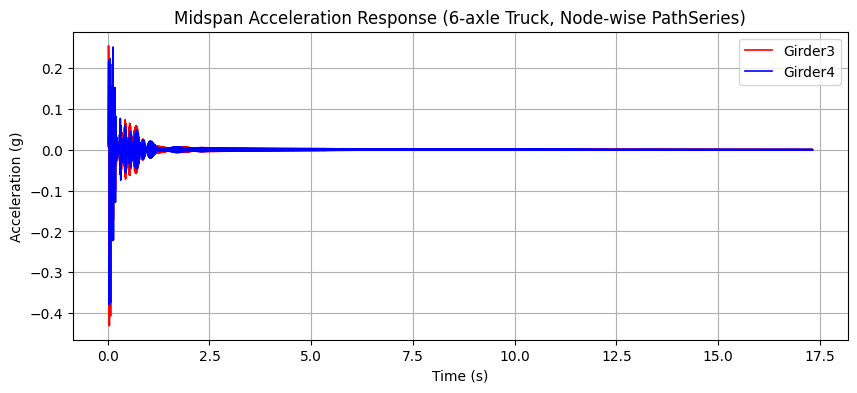

In [ ]:
build_bridge_model()

# ------------------------------------------------------------
# 0️⃣ Geometry setup
# ------------------------------------------------------------
girder3 = ops.getNodeTags()[np.where(np.array(ops.getNodeTags()) == 3001)[0][0]:
                            np.where(np.array(ops.getNodeTags()) == 3001)[0][0] + 149]
girder4 = ops.getNodeTags()[np.where(np.array(ops.getNodeTags()) == 4001)[0][0]:
                            np.where(np.array(ops.getNodeTags()) == 4001)[0][0] + 149]

coords_g3 = np.array([ops.nodeCoord(nd) for nd in girder3])
coords_g4 = np.array([ops.nodeCoord(nd) for nd in girder4])
x_g3, y_g3 = coords_g3[:, 0], coords_g3[:, 1]
x_g4, y_g4 = coords_g4[:, 0], coords_g4[:, 1]
bridge_length = abs(x_g3[-1] - x_g3[0])

print(f"✅ Girder3: {len(girder3)} nodes, Girder4: {len(girder4)} nodes, Length = {bridge_length:.1f} mm")

# ------------------------------------------------------------
# 1️⃣ Vehicle configuration (6-axle truck)
# ------------------------------------------------------------
vehicle_config = {
    'loads': [61300.0/2, 114700.0/2, 110820.0/2,
              61300.0/2, 114700.0/2, 110820.0/2],  # [N]
    'distances': [0.0, 3300.0, 4600.0,
                  0.0, 3300.0, 4600.0]  # [mm]
}
velocity_kmh = 10
speed = velocity_kmh * 1000 * 1000 / 3600  # [mm/s]

x_start_g3, y_start_g3 = x_g3[-1], y_g3[-1]
x_start_g4, y_start_g4 = x_g4[-1], y_g4[-1]

dt = 0.01
truck_length = abs(max(vehicle_config['distances']))
t_total = (bridge_length + truck_length) / speed
time_steps = np.arange(0, t_total + 5, dt)

# ------------------------------------------------------------
# 2️⃣ Node-wise load history initialization
# ------------------------------------------------------------
node_load_history_g3 = {nd: np.zeros(len(time_steps)) for nd in girder3}
node_load_history_g4 = {nd: np.zeros(len(time_steps)) for nd in girder4}

def get_axle_positions(t):
    return [speed * t + d for d in vehicle_config['distances']]

# ------------------------------------------------------------
# 3️⃣ Load history generation
# ------------------------------------------------------------
for it, t in enumerate(time_steps):
    progress = speed * t

    for i_ax, (dist, load_val) in enumerate(zip(vehicle_config['distances'], vehicle_config['loads'])):
        if i_ax < 3:
            x_axle = x_start_g3 - progress + dist
            x_g, girder, node_hist = x_g3, girder3, node_load_history_g3
        else:
            x_axle = x_start_g4 - progress + dist
            x_g, girder, node_hist = x_g4, girder4, node_load_history_g4

        if x_g[0] <= x_axle <= x_g[-1]:
            idx = np.searchsorted(x_g, x_axle) - 1
            idx = np.clip(idx, 0, len(girder) - 2)
            xi, xj = x_g[idx], x_g[idx + 1]
            nd_i, nd_j = girder[idx], girder[idx + 1]
            r = (x_axle - xi) / (xj - xi)
            node_hist[nd_i][it] += load_val * (1 - r)
            node_hist[nd_j][it] += load_val * r

print("✅ Node-wise load histories generated for both girders.")

# ------------------------------------------------------------
# 4️⃣ Analysis setup
# ------------------------------------------------------------
ops.wipeAnalysis()

omega_list = np.sqrt(eigen_value)
omega1, omega2 = omega_list[0], omega_list[2]
zeta = 0.015 # damping value
alphaM = zeta * (2 * omega1 * omega2) / (omega1 + omega2)
betaK = 2 * zeta / (omega1 + omega2)
ops.rayleigh(alphaM, 0., 0., betaK)

ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('SparseGeneral')
ops.test('NormDispIncr', 1e-5, 10)
ops.algorithm('Newton')
ops.integrator('Newmark', 0.5, 0.25)
ops.analysis('Transient')


# ------------------------------------------------------------
# 5️⃣ Recorders
# ------------------------------------------------------------
mid_node_g3 = girder3[len(girder3)//2]
mid_node_g4 = girder4[len(girder4)//2]
g3_text = '(before_update)mid_accel_g3.csv'
g4_text = '(before_update)mid_accel_g4.csv'

ops.recorder('Node', '-file', g3_text, '-time', '-node', mid_node_g3, '-dof', 3, 'accel')
ops.recorder('Node', '-file', g4_text, '-time', '-node', mid_node_g4, '-dof', 3, 'accel')

# ------------------------------------------------------------
# 6️⃣ Create PathSeries (노드별, girder별 오프셋 적용)
# ------------------------------------------------------------
def create_pathseries_from_history(history_dict, girder_id):
    for nd in history_dict:
        values = history_dict[nd]
        if np.allclose(values, 0.0):
            continue
        ts_tag = 1000 * girder_id + nd
        pat_tag = 2000 * girder_id + nd
        ops.timeSeries('Path', ts_tag, '-dt', dt, '-values', *values.tolist(), '-factor', 1.0)
        ops.pattern('Plain', pat_tag, ts_tag)
        ops.load(nd, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0)

create_pathseries_from_history(node_load_history_g3, 3)
create_pathseries_from_history(node_load_history_g4, 4)
print("✅ PathSeries created (node-wise, unique tags).")

# ------------------------------------------------------------
# 7️⃣ Run analysis
# ------------------------------------------------------------
ops.analyze(len(time_steps), dt)
print("✅ Analysis completed.")

# ------------------------------------------------------------
# 8️⃣ Plot results
# ------------------------------------------------------------
data_g3 = np.loadtxt(g3_text)
data_g4 = np.loadtxt(g4_text)

t = data_g3[:, 0]
acc_g3 = data_g3[:, 1] / 9.81 / 1000
acc_g4 = data_g4[:, 1] / 9.81 / 1000

plt.figure(figsize=(10, 4))
plt.plot(t, acc_g3, 'r-', lw=1.2, label='Girder3')
plt.plot(t, acc_g4, 'b-', lw=1.2, label='Girder4')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Midspan Acceleration Response (6-axle Truck, Node-wise PathSeries)')
plt.legend()
plt.grid(True)
plt.show()


✅ Bridge model successfully built.
✅ Girder3: 149 nodes, Girder4: 149 nodes, Length = 29600.0 mm
✅ Node-wise load histories generated for both girders.
✅ PathSeries created (node-wise, unique tags).
✅ Analysis completed.


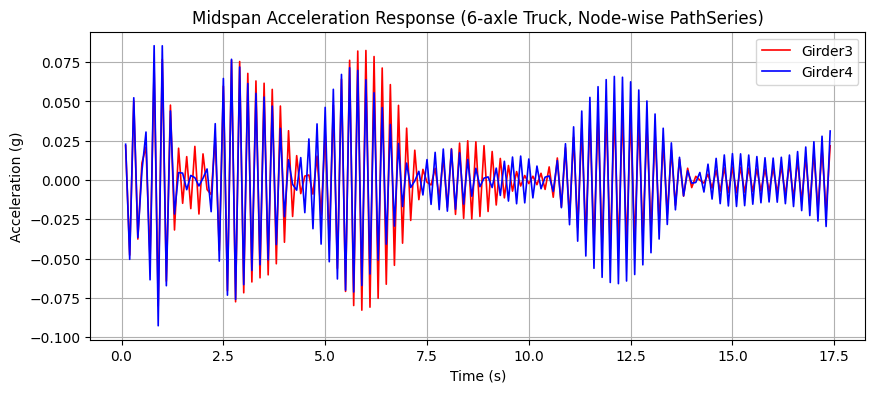

In [40]:
build_bridge_model()

# ------------------------------------------------------------
# 0️⃣ Geometry setup
# ------------------------------------------------------------
girder3 = ops.getNodeTags()[np.where(np.array(ops.getNodeTags()) == 3001)[0][0]:
                            np.where(np.array(ops.getNodeTags()) == 3001)[0][0] + 149]
girder4 = ops.getNodeTags()[np.where(np.array(ops.getNodeTags()) == 4001)[0][0]:
                            np.where(np.array(ops.getNodeTags()) == 4001)[0][0] + 149]

coords_g3 = np.array([ops.nodeCoord(nd) for nd in girder3])
coords_g4 = np.array([ops.nodeCoord(nd) for nd in girder4])
x_g3, y_g3 = coords_g3[:, 0], coords_g3[:, 1]
x_g4, y_g4 = coords_g4[:, 0], coords_g4[:, 1]
bridge_length = abs(x_g3[-1] - x_g3[0])

print(f"✅ Girder3: {len(girder3)} nodes, Girder4: {len(girder4)} nodes, Length = {bridge_length:.1f} mm")

# ------------------------------------------------------------
# 1️⃣ Vehicle configuration (6-axle truck)
# ------------------------------------------------------------
vehicle_config = {
    'loads': [61300.0/2, 114700.0/2, 110820.0/2,
              61300.0/2, 114700.0/2, 110820.0/2],  # [N]
    'distances': [0.0, 3300.0, 4600.0,
                  0.0, 3300.0, 4600.0]  # [mm]
}
velocity_kmh = 10
speed = velocity_kmh * 1000 * 1000 / 3600  # [mm/s]

x_start_g3, y_start_g3 = x_g3[-1], y_g3[-1]
x_start_g4, y_start_g4 = x_g4[-1], y_g4[-1]

dt = 0.1
truck_length = abs(max(vehicle_config['distances']))
t_total = (bridge_length + truck_length) / speed
time_steps = np.arange(0, t_total + 5, dt)

# ------------------------------------------------------------
# 2️⃣ Node-wise load history initialization
# ------------------------------------------------------------
node_load_history_g3 = {nd: np.zeros(len(time_steps)) for nd in girder3}
node_load_history_g4 = {nd: np.zeros(len(time_steps)) for nd in girder4}

def get_axle_positions(t):
    return [speed * t + d for d in vehicle_config['distances']]

# ------------------------------------------------------------
# 3️⃣ Load history generation
# ------------------------------------------------------------
for it, t in enumerate(time_steps):
    progress = speed * t

    for i_ax, (dist, load_val) in enumerate(zip(vehicle_config['distances'], vehicle_config['loads'])):
        if i_ax < 3:
            x_axle = x_start_g3 - progress + dist
            x_g, girder, node_hist = x_g3, girder3, node_load_history_g3
        else:
            x_axle = x_start_g4 - progress + dist
            x_g, girder, node_hist = x_g4, girder4, node_load_history_g4

        if x_g[0] <= x_axle <= x_g[-1]:
            idx = np.searchsorted(x_g, x_axle) - 1
            idx = np.clip(idx, 0, len(girder) - 2)
            xi, xj = x_g[idx], x_g[idx + 1]
            nd_i, nd_j = girder[idx], girder[idx + 1]
            r = (x_axle - xi) / (xj - xi)
            node_hist[nd_i][it] += load_val * (1 - r)
            node_hist[nd_j][it] += load_val * r

print("✅ Node-wise load histories generated for both girders.")

# ------------------------------------------------------------
# 4️⃣ Analysis setup
# ------------------------------------------------------------
ops.wipeAnalysis()

omega_list = np.sqrt(eigen_value)
omega1, omega2 = omega_list[0], omega_list[2]
zeta = 0.015 # damping value
alphaM = zeta * (2 * omega1 * omega2) / (omega1 + omega2)
betaK = 2 * zeta / (omega1 + omega2)
ops.rayleigh(alphaM, 0., 0., betaK)

ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('SparseGeneral')
ops.test('NormDispIncr', 1e-5, 10)
ops.algorithm('Newton')
ops.integrator('Newmark', 0.5, 0.25)
ops.analysis('Transient')


# ------------------------------------------------------------
# 5️⃣ Recorders
# ------------------------------------------------------------
mid_node_g3 = girder3[len(girder3)//2]
mid_node_g4 = girder4[len(girder4)//2]
g3_text = '(before_update dt = 0.1)mid_accel_g3.csv'
g4_text = '(before_update dt = 0.1)mid_accel_g4.csv'

ops.recorder('Node', '-file', g3_text, '-time', '-node', mid_node_g3, '-dof', 3, 'accel')
ops.recorder('Node', '-file', g4_text, '-time', '-node', mid_node_g4, '-dof', 3, 'accel')

# ------------------------------------------------------------
# 6️⃣ Create PathSeries (노드별, girder별 오프셋 적용)
# ------------------------------------------------------------
def create_pathseries_from_history(history_dict, girder_id):
    for nd in history_dict:
        values = history_dict[nd]
        if np.allclose(values, 0.0):
            continue
        ts_tag = 1000 * girder_id + nd
        pat_tag = 2000 * girder_id + nd
        ops.timeSeries('Path', ts_tag, '-dt', dt, '-values', *values.tolist(), '-factor', 1.0)
        ops.pattern('Plain', pat_tag, ts_tag)
        ops.load(nd, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0)

create_pathseries_from_history(node_load_history_g3, 3)
create_pathseries_from_history(node_load_history_g4, 4)
print("✅ PathSeries created (node-wise, unique tags).")

# ------------------------------------------------------------
# 7️⃣ Run analysis
# ------------------------------------------------------------
ops.analyze(len(time_steps), dt)
print("✅ Analysis completed.")

# ------------------------------------------------------------
# 8️⃣ Plot results
# ------------------------------------------------------------
data_g3 = np.loadtxt(g3_text)
data_g4 = np.loadtxt(g4_text)

t = data_g3[:, 0]
acc_g3 = data_g3[:, 1] / 9.81 / 1000
acc_g4 = data_g4[:, 1] / 9.81 / 1000

plt.figure(figsize=(10, 4))
plt.plot(t, acc_g3, 'r-', lw=1.2, label='Girder3')
plt.plot(t, acc_g4, 'b-', lw=1.2, label='Girder4')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Midspan Acceleration Response (6-axle Truck, Node-wise PathSeries)')
plt.legend()
plt.grid(True)
plt.show()


✅ Bridge model successfully built.
[1504.1399052236254, 4045.1937996334896, 6776.167004704005]
✅ Bridge model successfully built.
✅ Girder3: 149 nodes, Girder4: 149 nodes, Length = 29600.0 mm
✅ Node-wise load histories generated for both girders.
✅ PathSeries created (node-wise, unique tags).
✅ Analysis completed.


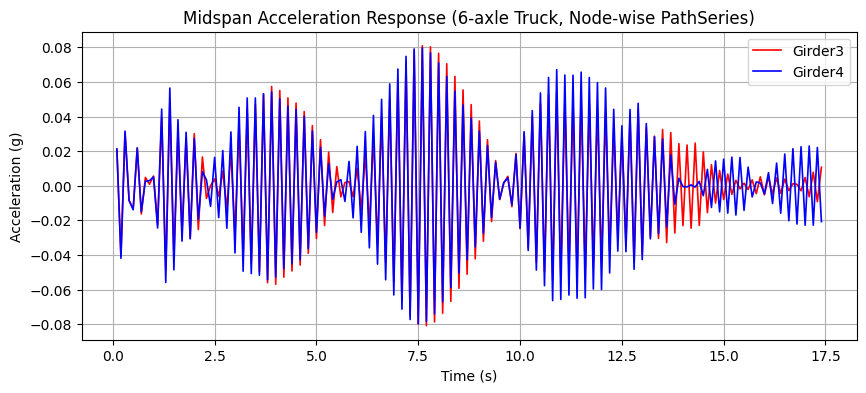

In [44]:
E_girder1 = [28000] * girder_number * 2   # 21000 → 18000 (균열 고려 35% 감소)
E_girder2 = [28000] * girder_number * 2   # 21000 → 18000 (균열 고려 35% 감소)


E_deck1 =  [25000] * (girder_number + 1)  # 20000 → 17000 (균열 고려)
E_deck2 =  [25000] * (girder_number + 1)  # 20000 → 17000 (균열 고려)

## 바닥판 두께는 250, 30MPa로 가기
thickness1 =[250] * (girder_number + 2)  # 거더 + 캔틸레버 수 만큼 
thickness2 = [250] * (girder_number + 2)  # 거더 + 캔틸레버 수 만큼 

#A1 11, 10, 10, 10, 10, 10     x(교축), y(교축직각)
#A2 01, 00, 00, 00, 00, 00

# 순서는 교축, 교축직각, 수직  단위 kn/m
free = 0 #kn/m 단위
consts = 1e9/1e3  #kn/m 단위
consts1 = 80000  # 80000 → 35000 (kN/m)
consts_crack = 1e9/1e4
A1_B1 =  [free, consts1, consts, 0, 0, 0]
A1_B2 =  [free, consts1, consts, 0, 0, 0]
A1_B3 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B4 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B5 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B6 =  [free, consts1, consts, 0, 0, 0]

A2_B1 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B2 =  [consts1, free, consts, 0, 0, 0]
A2_B3 =  [consts1, free, consts_crack, 0, 0, 0]   ## [kh, kh, kv, 0, 0, 0]  #[constraints, constraints, kv] 현재 코드에서는 입력조건과 관계없이 회전강성은 모두 0
A2_B4 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B5 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B6 =  [consts1, consts1, consts, 0, 0, 0]


Bearing_Stiffness_A1 = np.vstack((A1_B1, A1_B2, A1_B3, A1_B4, A1_B5, A1_B6))  * 0.3 
Bearing_Stiffness_A2 = np.vstack((A2_B1, A2_B2, A2_B3, A2_B4, A2_B5, A2_B6))

Bearing_Stiffness = np.vstack((Bearing_Stiffness_A1, Bearing_Stiffness_A2))

load_case_num = 1
load = -290*1000/2  #N 단위 (49ton트럭하중 재하)

PE = 600  # 350 → 200 MPa (장기손실 + 균열 + 이완 고려) 

diaphragm1_Ec =[24000]*5  # 열기준 배치 수 만큼 (거더 사이 = (거더수-1) )  # 열기준 배치 수 만큼 (거더 사이 = (거더수-1) )
diaphragm2_Ec = [24000]*5   # 가로보 
pave_thick = [80]

def find_indices_within_tol(array, values, tol=1e-3):
    idx_list = []
    for v in values:
        idx = np.where(np.abs(array - v) < tol)[0]
        if idx.size > 0:
            idx_list.append(idx[0])
    return np.array(idx_list)


build_bridge_model()
eigen_value = ops.eigen(numEigen)
print(eigen_value)
build_bridge_model()

# ------------------------------------------------------------
# 0️⃣ Geometry setup
# ------------------------------------------------------------
girder3 = ops.getNodeTags()[np.where(np.array(ops.getNodeTags()) == 3001)[0][0]:
                            np.where(np.array(ops.getNodeTags()) == 3001)[0][0] + 149]
girder4 = ops.getNodeTags()[np.where(np.array(ops.getNodeTags()) == 4001)[0][0]:
                            np.where(np.array(ops.getNodeTags()) == 4001)[0][0] + 149]

coords_g3 = np.array([ops.nodeCoord(nd) for nd in girder3])
coords_g4 = np.array([ops.nodeCoord(nd) for nd in girder4])
x_g3, y_g3 = coords_g3[:, 0], coords_g3[:, 1]
x_g4, y_g4 = coords_g4[:, 0], coords_g4[:, 1]
bridge_length = abs(x_g3[-1] - x_g3[0])

print(f"✅ Girder3: {len(girder3)} nodes, Girder4: {len(girder4)} nodes, Length = {bridge_length:.1f} mm")

# ------------------------------------------------------------
# 1️⃣ Vehicle configuration (6-axle truck)
# ------------------------------------------------------------
vehicle_config = {
    'loads': [61300.0/2, 114700.0/2, 110820.0/2,
              61300.0/2, 114700.0/2, 110820.0/2],  # [N]
    'distances': [0.0, 3300.0, 4600.0,
                  0.0, 3300.0, 4600.0]  # [mm]
}
velocity_kmh = 10
speed = velocity_kmh * 1000 * 1000 / 3600  # [mm/s]

x_start_g3, y_start_g3 = x_g3[-1], y_g3[-1]
x_start_g4, y_start_g4 = x_g4[-1], y_g4[-1]

dt = 0.1
truck_length = abs(max(vehicle_config['distances']))
t_total = (bridge_length + truck_length) / speed
time_steps = np.arange(0, t_total + 5, dt)

# ------------------------------------------------------------
# 2️⃣ Node-wise load history initialization
# ------------------------------------------------------------
node_load_history_g3 = {nd: np.zeros(len(time_steps)) for nd in girder3}
node_load_history_g4 = {nd: np.zeros(len(time_steps)) for nd in girder4}

def get_axle_positions(t):
    return [speed * t + d for d in vehicle_config['distances']]

# ------------------------------------------------------------
# 3️⃣ Load history generation
# ------------------------------------------------------------
for it, t in enumerate(time_steps):
    progress = speed * t

    for i_ax, (dist, load_val) in enumerate(zip(vehicle_config['distances'], vehicle_config['loads'])):
        if i_ax < 3:
            x_axle = x_start_g3 - progress + dist
            x_g, girder, node_hist = x_g3, girder3, node_load_history_g3
        else:
            x_axle = x_start_g4 - progress + dist
            x_g, girder, node_hist = x_g4, girder4, node_load_history_g4

        if x_g[0] <= x_axle <= x_g[-1]:
            idx = np.searchsorted(x_g, x_axle) - 1
            idx = np.clip(idx, 0, len(girder) - 2)
            xi, xj = x_g[idx], x_g[idx + 1]
            nd_i, nd_j = girder[idx], girder[idx + 1]
            r = (x_axle - xi) / (xj - xi)
            node_hist[nd_i][it] += load_val * (1 - r)
            node_hist[nd_j][it] += load_val * r

print("✅ Node-wise load histories generated for both girders.")

# ------------------------------------------------------------
# 4️⃣ Analysis setup
# ------------------------------------------------------------
ops.wipeAnalysis()

omega_list = np.sqrt(eigen_value)
omega1, omega2 = omega_list[0], omega_list[2]
zeta = 0.015 # damping value
alphaM = zeta * (2 * omega1 * omega2) / (omega1 + omega2)
betaK = 2 * zeta / (omega1 + omega2)
ops.rayleigh(alphaM, 0., 0., betaK)

ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('SparseGeneral')
ops.test('NormDispIncr', 1e-5, 10)
ops.algorithm('Newton')
ops.integrator('Newmark', 0.5, 0.25)
ops.analysis('Transient')

# ------------------------------------------------------------
# 5️⃣ Recorders
# ------------------------------------------------------------
mid_node_g3 = girder3[len(girder3)//2]
mid_node_g4 = girder4[len(girder4)//2]
g3_text = '(case1)mid_accel_g3.csv'
g4_text = '(case1)mid_accel_g4.csv'

ops.recorder('Node', '-file', g3_text, '-time', '-node', mid_node_g3, '-dof', 3, 'accel')
ops.recorder('Node', '-file', g4_text, '-time', '-node', mid_node_g4, '-dof', 3, 'accel')

# ------------------------------------------------------------
# 6️⃣ Create PathSeries (노드별, girder별 오프셋 적용)
# ------------------------------------------------------------
def create_pathseries_from_history(history_dict, girder_id):
    for nd in history_dict:
        values = history_dict[nd]
        if np.allclose(values, 0.0):
            continue
        ts_tag = 1000 * girder_id + nd
        pat_tag = 2000 * girder_id + nd
        ops.timeSeries('Path', ts_tag, '-dt', dt, '-values', *values.tolist(), '-factor', 1.0)
        ops.pattern('Plain', pat_tag, ts_tag)
        ops.load(nd, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0)

create_pathseries_from_history(node_load_history_g3, 3)
create_pathseries_from_history(node_load_history_g4, 4)
print("✅ PathSeries created (node-wise, unique tags).")

# ------------------------------------------------------------
# 7️⃣ Run analysis
# ------------------------------------------------------------
ops.analyze(len(time_steps), dt)
print("✅ Analysis completed.")

# ------------------------------------------------------------
# 8️⃣ Plot results
# ------------------------------------------------------------
data_g3 = np.loadtxt(g3_text)
data_g4 = np.loadtxt(g4_text)

t = data_g3[:, 0]
acc_g3 = data_g3[:, 1] / 9.81 / 1000
acc_g4 = data_g4[:, 1] / 9.81 / 1000

plt.figure(figsize=(10, 4))
plt.plot(t, acc_g3, 'r-', lw=1.2, label='Girder3')
plt.plot(t, acc_g4, 'b-', lw=1.2, label='Girder4')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Midspan Acceleration Response (6-axle Truck, Node-wise PathSeries)')
plt.legend()
plt.grid(True)
plt.show()


✅ Bridge model successfully built.
[1712.7559303421965, 4178.744701704752, 7211.278107029002]
✅ Bridge model successfully built.
✅ Girder3: 149 nodes, Girder4: 149 nodes, Length = 29600.0 mm
✅ Node-wise load histories generated for both girders.
✅ PathSeries created (node-wise, unique tags).
✅ Analysis completed.


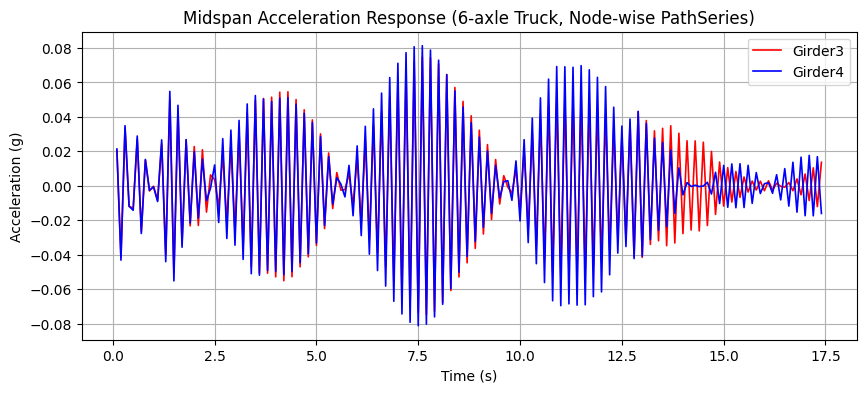

In [45]:
########### case2

E_girder1 = [28000] * girder_number * 2   # 21000 → 18000 (균열 고려 35% 감소)
E_girder2 = [28000] * girder_number * 2   # 21000 → 18000 (균열 고려 35% 감소)


E_deck1 =  [25000] * (girder_number + 1)  # 20000 → 17000 (균열 고려)
E_deck2 =  [25000] * (girder_number + 1)  # 20000 → 17000 (균열 고려)

## 바닥판 두께는 250, 30MPa로 가기
thickness1 =[250] * (girder_number + 2)  # 거더 + 캔틸레버 수 만큼 
thickness2 = [250] * (girder_number + 2)  # 거더 + 캔틸레버 수 만큼 

#A1 11, 10, 10, 10, 10, 10     x(교축), y(교축직각)
#A2 01, 00, 00, 00, 00, 00

# 순서는 교축, 교축직각, 수직  단위 kn/m
free = 0 #kn/m 단위
consts = 1e9/1e3  #kn/m 단위
consts1 = 80000  # 80000 → 35000 (kN/m)
consts_crack = 1e9/1e4
A1_B1 =  [free, consts1, consts, 0, 0, 0]
A1_B2 =  [free, consts1, consts, 0, 0, 0]
A1_B3 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B4 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B5 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B6 =  [free, consts1, consts, 0, 0, 0]

A2_B1 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B2 =  [consts1, free, consts, 0, 0, 0]
A2_B3 =  [consts1, free, consts_crack, 0, 0, 0]   ## [kh, kh, kv, 0, 0, 0]  #[constraints, constraints, kv] 현재 코드에서는 입력조건과 관계없이 회전강성은 모두 0
A2_B4 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B5 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B6 =  [consts1, consts1, consts, 0, 0, 0]


Bearing_Stiffness_A1 = np.vstack((A1_B1, A1_B2, A1_B3, A1_B4, A1_B5, A1_B6))  * 0.5 
Bearing_Stiffness_A2 = np.vstack((A2_B1, A2_B2, A2_B3, A2_B4, A2_B5, A2_B6))

Bearing_Stiffness = np.vstack((Bearing_Stiffness_A1, Bearing_Stiffness_A2))

load_case_num = 1
load = -290*1000/2  #N 단위 (49ton트럭하중 재하)

PE = 600  # 350 → 200 MPa (장기손실 + 균열 + 이완 고려) 

diaphragm1_Ec =[24000]*5  # 열기준 배치 수 만큼 (거더 사이 = (거더수-1) )  # 열기준 배치 수 만큼 (거더 사이 = (거더수-1) )
diaphragm2_Ec = [24000]*5   # 가로보 
pave_thick = [80]

def find_indices_within_tol(array, values, tol=1e-3):
    idx_list = []
    for v in values:
        idx = np.where(np.abs(array - v) < tol)[0]
        if idx.size > 0:
            idx_list.append(idx[0])
    return np.array(idx_list)

build_bridge_model()
eigen_value = ops.eigen(numEigen)
print(eigen_value)
build_bridge_model()

# ------------------------------------------------------------
# 0️⃣ Geometry setup
# ------------------------------------------------------------
girder3 = ops.getNodeTags()[np.where(np.array(ops.getNodeTags()) == 3001)[0][0]:
                            np.where(np.array(ops.getNodeTags()) == 3001)[0][0] + 149]
girder4 = ops.getNodeTags()[np.where(np.array(ops.getNodeTags()) == 4001)[0][0]:
                            np.where(np.array(ops.getNodeTags()) == 4001)[0][0] + 149]

coords_g3 = np.array([ops.nodeCoord(nd) for nd in girder3])
coords_g4 = np.array([ops.nodeCoord(nd) for nd in girder4])
x_g3, y_g3 = coords_g3[:, 0], coords_g3[:, 1]
x_g4, y_g4 = coords_g4[:, 0], coords_g4[:, 1]
bridge_length = abs(x_g3[-1] - x_g3[0])

print(f"✅ Girder3: {len(girder3)} nodes, Girder4: {len(girder4)} nodes, Length = {bridge_length:.1f} mm")

# ------------------------------------------------------------
# 1️⃣ Vehicle configuration (6-axle truck)
# ------------------------------------------------------------
vehicle_config = {
    'loads': [61300.0/2, 114700.0/2, 110820.0/2,
              61300.0/2, 114700.0/2, 110820.0/2],  # [N]
    'distances': [0.0, 3300.0, 4600.0,
                  0.0, 3300.0, 4600.0]  # [mm]
}
velocity_kmh = 10
speed = velocity_kmh * 1000 * 1000 / 3600  # [mm/s]

x_start_g3, y_start_g3 = x_g3[-1], y_g3[-1]
x_start_g4, y_start_g4 = x_g4[-1], y_g4[-1]

dt = 0.1
truck_length = abs(max(vehicle_config['distances']))
t_total = (bridge_length + truck_length) / speed
time_steps = np.arange(0, t_total + 5, dt)

# ------------------------------------------------------------
# 2️⃣ Node-wise load history initialization
# ------------------------------------------------------------
node_load_history_g3 = {nd: np.zeros(len(time_steps)) for nd in girder3}
node_load_history_g4 = {nd: np.zeros(len(time_steps)) for nd in girder4}

def get_axle_positions(t):
    return [speed * t + d for d in vehicle_config['distances']]

# ------------------------------------------------------------
# 3️⃣ Load history generation
# ------------------------------------------------------------
for it, t in enumerate(time_steps):
    progress = speed * t

    for i_ax, (dist, load_val) in enumerate(zip(vehicle_config['distances'], vehicle_config['loads'])):
        if i_ax < 3:
            x_axle = x_start_g3 - progress + dist
            x_g, girder, node_hist = x_g3, girder3, node_load_history_g3
        else:
            x_axle = x_start_g4 - progress + dist
            x_g, girder, node_hist = x_g4, girder4, node_load_history_g4

        if x_g[0] <= x_axle <= x_g[-1]:
            idx = np.searchsorted(x_g, x_axle) - 1
            idx = np.clip(idx, 0, len(girder) - 2)
            xi, xj = x_g[idx], x_g[idx + 1]
            nd_i, nd_j = girder[idx], girder[idx + 1]
            r = (x_axle - xi) / (xj - xi)
            node_hist[nd_i][it] += load_val * (1 - r)
            node_hist[nd_j][it] += load_val * r

print("✅ Node-wise load histories generated for both girders.")

# ------------------------------------------------------------
# 4️⃣ Analysis setup
# ------------------------------------------------------------
ops.wipeAnalysis()

omega_list = np.sqrt(eigen_value)
omega1, omega2 = omega_list[0], omega_list[2]
zeta = 0.015 # damping value
alphaM = zeta * (2 * omega1 * omega2) / (omega1 + omega2)
betaK = 2 * zeta / (omega1 + omega2)
ops.rayleigh(alphaM, 0., 0., betaK)

ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('SparseGeneral')
ops.test('NormDispIncr', 1e-5, 10)
ops.algorithm('Newton')
ops.integrator('Newmark', 0.5, 0.25)
ops.analysis('Transient')


# ------------------------------------------------------------
# 5️⃣ Recorders
# ------------------------------------------------------------
mid_node_g3 = girder3[len(girder3)/2]
mid_node_g4 = girder4[len(girder4)/2]
g3_text = '(case2)mid_accel_g3.csv'
g4_text = '(case2)mid_accel_g4.csv'

ops.recorder('Node', '-file', g3_text, '-time', '-node', mid_node_g3, '-dof', 3, 'accel')
ops.recorder('Node', '-file', g4_text, '-time', '-node', mid_node_g4, '-dof', 3, 'accel')

# ------------------------------------------------------------
# 6️⃣ Create PathSeries (노드별, girder별 오프셋 적용)
# ------------------------------------------------------------
def create_pathseries_from_history(history_dict, girder_id):
    for nd in history_dict:
        values = history_dict[nd]
        if np.allclose(values, 0.0):
            continue
        ts_tag = 1000 * girder_id + nd
        pat_tag = 2000 * girder_id + nd
        ops.timeSeries('Path', ts_tag, '-dt', dt, '-values', *values.tolist(), '-factor', 1.0)
        ops.pattern('Plain', pat_tag, ts_tag)
        ops.load(nd, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0)

create_pathseries_from_history(node_load_history_g3, 3)
create_pathseries_from_history(node_load_history_g4, 4)
print("✅ PathSeries created (node-wise, unique tags).")

# ------------------------------------------------------------
# 7️⃣ Run analysis
# ------------------------------------------------------------
ops.analyze(len(time_steps), dt)
print("✅ Analysis completed.")

# ------------------------------------------------------------
# 8️⃣ Plot results
# ------------------------------------------------------------
data_g3 = np.loadtxt(g3_text)
data_g4 = np.loadtxt(g4_text)

t = data_g3[:, 0]
acc_g3 = data_g3[:, 1] / 9.81 / 1000
acc_g4 = data_g4[:, 1] / 9.81 / 1000

plt.figure(figsize=(10, 4))
plt.plot(t, acc_g3, 'r-', lw=1.2, label='Girder3')
plt.plot(t, acc_g4, 'b-', lw=1.2, label='Girder4')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Midspan Acceleration Response (6-axle Truck, Node-wise PathSeries)')
plt.legend()
plt.grid(True)
plt.show()

✅ Bridge model successfully built.
[1932.1110708180768, 4311.483637462538, 7725.741274516452]
✅ Bridge model successfully built.
✅ Girder3: 149 nodes, Girder4: 149 nodes, Length = 29600.0 mm
✅ Node-wise load histories generated for both girders.
✅ PathSeries created (node-wise, unique tags).
✅ Analysis completed.


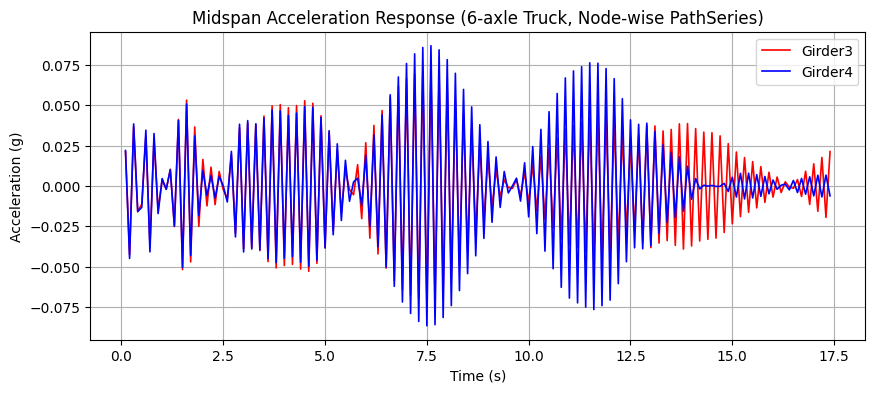

In [46]:
################################ Case 5

E_girder1 = [28000 * 0.7, 28000, 28000, 28000, 28000, 28000]    # 21000 → 18000 (균열 고려 35% 감소)
E_deck1 =  [25000] * (girder_number + 1)  # 20000 → 17000 (균열 고려)

## 바닥판 두께는 250, 30MPa로 가기
thickness1 =[250] * (girder_number + 2)  # 거더 + 캔틸레버 수 만큼 

#A1 11, 10, 10, 10, 10, 10     x(교축), y(교축직각)
#A2 01, 00, 00, 00, 00, 00

# 순서는 교축, 교축직각, 수직  단위 kn/m
free = 0 #kn/m 단위
consts = 1e9/1e3  #kn/m 단위
consts1 = 80000  # 80000 → 35000 (kN/m)
consts_crack = 1e9/1e4
A1_B1 =  [free, consts1, consts, 0, 0, 0]
A1_B2 =  [free, consts1, consts, 0, 0, 0]
A1_B3 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B4 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B5 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B6 =  [free, consts1, consts, 0, 0, 0]

A2_B1 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B2 =  [consts1, free, consts, 0, 0, 0]
A2_B3 =  [consts1, free, consts_crack, 0, 0, 0]   ## [kh, kh, kv, 0, 0, 0]  #[constraints, constraints, kv] 현재 코드에서는 입력조건과 관계없이 회전강성은 모두 0
A2_B4 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B5 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B6 =  [consts1, consts1, consts, 0, 0, 0]


Bearing_Stiffness_A1 = np.vstack((A1_B1, A1_B2, A1_B3, A1_B4, A1_B5, A1_B6))
Bearing_Stiffness_A2 = np.vstack((A2_B1, A2_B2, A2_B3, A2_B4, A2_B5, A2_B6))

Bearing_Stiffness = np.vstack((Bearing_Stiffness_A1, Bearing_Stiffness_A2))

load_case_num = 1
load = -290*1000/2  #N 단위 (49ton트럭하중 재하)

PE = 600  # 350 → 200 MPa (장기손실 + 균열 + 이완 고려) 

diaphragm1_Ec =[24000]*5  # 열기준 배치 수 만큼 (거더 사이 = (거더수-1) )  # 열기준 배치 수 만큼 (거더 사이 = (거더수-1) )
diaphragm2_Ec = [24000]*5   # 가로보 
pave_thick = [80]

def find_indices_within_tol(array, values, tol=1e-3):
    idx_list = []
    for v in values:
        idx = np.where(np.abs(array - v) < tol)[0]
        if idx.size > 0:
            idx_list.append(idx[0])
    return np.array(idx_list)



build_bridge_model()
eigen_value = ops.eigen(numEigen)
print(eigen_value)
build_bridge_model()

# ------------------------------------------------------------
# 0️⃣ Geometry setup
# ------------------------------------------------------------
girder3 = ops.getNodeTags()[np.where(np.array(ops.getNodeTags()) == 3001)[0][0]:
                            np.where(np.array(ops.getNodeTags()) == 3001)[0][0] + 149]
girder4 = ops.getNodeTags()[np.where(np.array(ops.getNodeTags()) == 4001)[0][0]:
                            np.where(np.array(ops.getNodeTags()) == 4001)[0][0] + 149]

coords_g3 = np.array([ops.nodeCoord(nd) for nd in girder3])
coords_g4 = np.array([ops.nodeCoord(nd) for nd in girder4])
x_g3, y_g3 = coords_g3[:, 0], coords_g3[:, 1]
x_g4, y_g4 = coords_g4[:, 0], coords_g4[:, 1]
bridge_length = abs(x_g3[-1] - x_g3[0])

print(f"✅ Girder3: {len(girder3)} nodes, Girder4: {len(girder4)} nodes, Length = {bridge_length:.1f} mm")

# ------------------------------------------------------------
# 1️⃣ Vehicle configuration (6-axle truck)
# ------------------------------------------------------------
vehicle_config = {
    'loads': [61300.0/2, 114700.0/2, 110820.0/2,
              61300.0/2, 114700.0/2, 110820.0/2],  # [N]
    'distances': [0.0, 3300.0, 4600.0,
                  0.0, 3300.0, 4600.0]  # [mm]
}
velocity_kmh = 10
speed = velocity_kmh * 1000 * 1000 / 3600  # [mm/s]

x_start_g3, y_start_g3 = x_g3[-1], y_g3[-1]
x_start_g4, y_start_g4 = x_g4[-1], y_g4[-1]

dt = 0.1
truck_length = abs(max(vehicle_config['distances']))
t_total = (bridge_length + truck_length) / speed
time_steps = np.arange(0, t_total + 5, dt)

# ------------------------------------------------------------
# 2️⃣ Node-wise load history initialization
# ------------------------------------------------------------
node_load_history_g3 = {nd: np.zeros(len(time_steps)) for nd in girder3}
node_load_history_g4 = {nd: np.zeros(len(time_steps)) for nd in girder4}

def get_axle_positions(t):
    return [speed * t + d for d in vehicle_config['distances']]

# ------------------------------------------------------------
# 3️⃣ Load history generation
# ------------------------------------------------------------
for it, t in enumerate(time_steps):
    progress = speed * t

    for i_ax, (dist, load_val) in enumerate(zip(vehicle_config['distances'], vehicle_config['loads'])):
        if i_ax < 3:
            x_axle = x_start_g3 - progress + dist
            x_g, girder, node_hist = x_g3, girder3, node_load_history_g3
        else:
            x_axle = x_start_g4 - progress + dist
            x_g, girder, node_hist = x_g4, girder4, node_load_history_g4

        if x_g[0] <= x_axle <= x_g[-1]:
            idx = np.searchsorted(x_g, x_axle) - 1
            idx = np.clip(idx, 0, len(girder) - 2)
            xi, xj = x_g[idx], x_g[idx + 1]
            nd_i, nd_j = girder[idx], girder[idx + 1]
            r = (x_axle - xi) / (xj - xi)
            node_hist[nd_i][it] += load_val * (1 - r)
            node_hist[nd_j][it] += load_val * r

print("✅ Node-wise load histories generated for both girders.")

# ------------------------------------------------------------
# 4️⃣ Analysis setup
# ------------------------------------------------------------
ops.wipeAnalysis()

omega_list = np.sqrt(eigen_value)
omega1, omega2 = omega_list[0], omega_list[2]
zeta = 0.015 # damping value
alphaM = zeta * (2 * omega1 * omega2) / (omega1 + omega2)
betaK = 2 * zeta / (omega1 + omega2)
ops.rayleigh(alphaM, 0., 0., betaK)

ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('SparseGeneral')
ops.test('NormDispIncr', 1e-5, 10)
ops.algorithm('Newton')
ops.integrator('Newmark', 0.5, 0.25)
ops.analysis('Transient')


# ------------------------------------------------------------
# 5️⃣ Recorders
# ------------------------------------------------------------
mid_node_g3 = girder3[len(girder3)//2]
mid_node_g4 = girder4[len(girder4)//2]
g3_text = '(case5)mid_accel_g3.csv'
g4_text = '(case5)mid_accel_g4.csv'

ops.recorder('Node', '-file', g3_text, '-time', '-node', mid_node_g3, '-dof', 3, 'accel')
ops.recorder('Node', '-file', g4_text, '-time', '-node', mid_node_g4, '-dof', 3, 'accel')

# ------------------------------------------------------------
# 6️⃣ Create PathSeries (노드별, girder별 오프셋 적용)
# ------------------------------------------------------------
def create_pathseries_from_history(history_dict, girder_id):
    for nd in history_dict:
        values = history_dict[nd]
        if np.allclose(values, 0.0):
            continue
        ts_tag = 1000 * girder_id + nd
        pat_tag = 2000 * girder_id + nd
        ops.timeSeries('Path', ts_tag, '-dt', dt, '-values', *values.tolist(), '-factor', 1.0)
        ops.pattern('Plain', pat_tag, ts_tag)
        ops.load(nd, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0)

create_pathseries_from_history(node_load_history_g3, 3)
create_pathseries_from_history(node_load_history_g4, 4)
print("✅ PathSeries created (node-wise, unique tags).")

# ------------------------------------------------------------
# 7️⃣ Run analysis
# ------------------------------------------------------------
ops.analyze(len(time_steps), dt)
print("✅ Analysis completed.")

# ------------------------------------------------------------
# 8️⃣ Plot results
# ------------------------------------------------------------
data_g3 = np.loadtxt(g3_text)
data_g4 = np.loadtxt(g4_text)

t = data_g3[:, 0]
acc_g3 = data_g3[:, 1] / 9.81 / 1000
acc_g4 = data_g4[:, 1] / 9.81 / 1000

plt.figure(figsize=(10, 4))
plt.plot(t, acc_g3, 'r-', lw=1.2, label='Girder3')
plt.plot(t, acc_g4, 'b-', lw=1.2, label='Girder4')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Midspan Acceleration Response (6-axle Truck, Node-wise PathSeries)')
plt.legend()
plt.grid(True)
plt.show()

✅ Bridge model successfully built.
[1925.7700251316794, 4301.70240809985, 7711.718407952901]
✅ Bridge model successfully built.
✅ Girder3: 149 nodes, Girder4: 149 nodes, Length = 29600.0 mm
✅ Node-wise load histories generated for both girders.
✅ PathSeries created (node-wise, unique tags).
✅ Analysis completed.


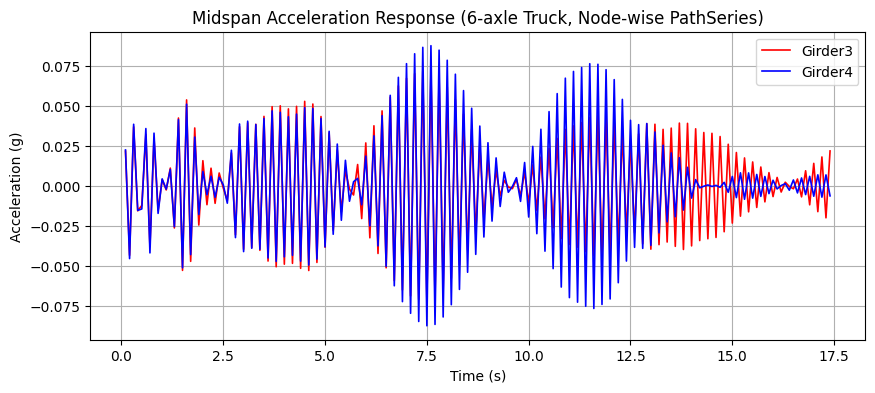

In [47]:
################################ Case 6

E_girder1 = [28000 * 0.5, 28000, 28000, 28000, 28000, 28000]    # 21000 → 18000 (균열 고려 35% 감소)
E_deck1 =  [25000] * (girder_number + 1)  # 20000 → 17000 (균열 고려)

## 바닥판 두께는 250, 30MPa로 가기
thickness1 =[250] * (girder_number + 2)  # 거더 + 캔틸레버 수 만큼 

#A1 11, 10, 10, 10, 10, 10     x(교축), y(교축직각)
#A2 01, 00, 00, 00, 00, 00

# 순서는 교축, 교축직각, 수직  단위 kn/m
free = 0 #kn/m 단위
consts = 1e9/1e3  #kn/m 단위
consts1 = 80000  # 80000 → 35000 (kN/m)
consts_crack = 1e9/1e4
A1_B1 =  [free, consts1, consts, 0, 0, 0]
A1_B2 =  [free, consts1, consts, 0, 0, 0]
A1_B3 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B4 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B5 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B6 =  [free, consts1, consts, 0, 0, 0]

A2_B1 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B2 =  [consts1, free, consts, 0, 0, 0]
A2_B3 =  [consts1, free, consts_crack, 0, 0, 0]   ## [kh, kh, kv, 0, 0, 0]  #[constraints, constraints, kv] 현재 코드에서는 입력조건과 관계없이 회전강성은 모두 0
A2_B4 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B5 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B6 =  [consts1, consts1, consts, 0, 0, 0]


Bearing_Stiffness_A1 = np.vstack((A1_B1, A1_B2, A1_B3, A1_B4, A1_B5, A1_B6))
Bearing_Stiffness_A2 = np.vstack((A2_B1, A2_B2, A2_B3, A2_B4, A2_B5, A2_B6))

Bearing_Stiffness = np.vstack((Bearing_Stiffness_A1, Bearing_Stiffness_A2))

load_case_num = 1
load = -290*1000/2  #N 단위 (49ton트럭하중 재하)

PE = 600  # 350 → 200 MPa (장기손실 + 균열 + 이완 고려) 

diaphragm1_Ec =[24000]*5  # 열기준 배치 수 만큼 (거더 사이 = (거더수-1) )  # 열기준 배치 수 만큼 (거더 사이 = (거더수-1) )
diaphragm2_Ec = [24000]*5   # 가로보 
pave_thick = [80]

def find_indices_within_tol(array, values, tol=1e-3):
    idx_list = []
    for v in values:
        idx = np.where(np.abs(array - v) < tol)[0]
        if idx.size > 0:
            idx_list.append(idx[0])
    return np.array(idx_list)



build_bridge_model()
eigen_value = ops.eigen(numEigen)
print(eigen_value)
build_bridge_model()

# ------------------------------------------------------------
# 0️⃣ Geometry setup
# ------------------------------------------------------------
girder3 = ops.getNodeTags()[np.where(np.array(ops.getNodeTags()) == 3001)[0][0]:
                            np.where(np.array(ops.getNodeTags()) == 3001)[0][0] + 149]
girder4 = ops.getNodeTags()[np.where(np.array(ops.getNodeTags()) == 4001)[0][0]:
                            np.where(np.array(ops.getNodeTags()) == 4001)[0][0] + 149]

coords_g3 = np.array([ops.nodeCoord(nd) for nd in girder3])
coords_g4 = np.array([ops.nodeCoord(nd) for nd in girder4])
x_g3, y_g3 = coords_g3[:, 0], coords_g3[:, 1]
x_g4, y_g4 = coords_g4[:, 0], coords_g4[:, 1]
bridge_length = abs(x_g3[-1] - x_g3[0])

print(f"✅ Girder3: {len(girder3)} nodes, Girder4: {len(girder4)} nodes, Length = {bridge_length:.1f} mm")

# ------------------------------------------------------------
# 1️⃣ Vehicle configuration (6-axle truck)
# ------------------------------------------------------------
vehicle_config = {
    'loads': [61300.0/2, 114700.0/2, 110820.0/2,
              61300.0/2, 114700.0/2, 110820.0/2],  # [N]
    'distances': [0.0, 3300.0, 4600.0,
                  0.0, 3300.0, 4600.0]  # [mm]
}
velocity_kmh = 10
speed = velocity_kmh * 1000 * 1000 / 3600  # [mm/s]

x_start_g3, y_start_g3 = x_g3[-1], y_g3[-1]
x_start_g4, y_start_g4 = x_g4[-1], y_g4[-1]

dt = 0.1
truck_length = abs(max(vehicle_config['distances']))
t_total = (bridge_length + truck_length) / speed
time_steps = np.arange(0, t_total + 5, dt)

# ------------------------------------------------------------
# 2️⃣ Node-wise load history initialization
# ------------------------------------------------------------
node_load_history_g3 = {nd: np.zeros(len(time_steps)) for nd in girder3}
node_load_history_g4 = {nd: np.zeros(len(time_steps)) for nd in girder4}

def get_axle_positions(t):
    return [speed * t + d for d in vehicle_config['distances']]

# ------------------------------------------------------------
# 3️⃣ Load history generation
# ------------------------------------------------------------
for it, t in enumerate(time_steps):
    progress = speed * t

    for i_ax, (dist, load_val) in enumerate(zip(vehicle_config['distances'], vehicle_config['loads'])):
        if i_ax < 3:
            x_axle = x_start_g3 - progress + dist
            x_g, girder, node_hist = x_g3, girder3, node_load_history_g3
        else:
            x_axle = x_start_g4 - progress + dist
            x_g, girder, node_hist = x_g4, girder4, node_load_history_g4

        if x_g[0] <= x_axle <= x_g[-1]:
            idx = np.searchsorted(x_g, x_axle) - 1
            idx = np.clip(idx, 0, len(girder) - 2)
            xi, xj = x_g[idx], x_g[idx + 1]
            nd_i, nd_j = girder[idx], girder[idx + 1]
            r = (x_axle - xi) / (xj - xi)
            node_hist[nd_i][it] += load_val * (1 - r)
            node_hist[nd_j][it] += load_val * r

print("✅ Node-wise load histories generated for both girders.")

# ------------------------------------------------------------
# 4️⃣ Analysis setup
# ------------------------------------------------------------
ops.wipeAnalysis()

omega_list = np.sqrt(eigen_value)
omega1, omega2 = omega_list[0], omega_list[2]
zeta = 0.015 # damping value
alphaM = zeta * (2 * omega1 * omega2) / (omega1 + omega2)
betaK = 2 * zeta / (omega1 + omega2)
ops.rayleigh(alphaM, 0., 0., betaK)

ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('SparseGeneral')
ops.test('NormDispIncr', 1e-5, 10)
ops.algorithm('Newton')
ops.integrator('Newmark', 0.5, 0.25)
ops.analysis('Transient')


# ------------------------------------------------------------
# 5️⃣ Recorders
# ------------------------------------------------------------
mid_node_g3 = girder3[len(girder3)//2]
mid_node_g4 = girder4[len(girder4)//2]
g3_text = '(case6)mid_accel_g3.csv'
g4_text = '(case6)mid_accel_g4.csv'

ops.recorder('Node', '-file', g3_text, '-time', '-node', mid_node_g3, '-dof', 3, 'accel')
ops.recorder('Node', '-file', g4_text, '-time', '-node', mid_node_g4, '-dof', 3, 'accel')

# ------------------------------------------------------------
# 6️⃣ Create PathSeries (노드별, girder별 오프셋 적용)
# ------------------------------------------------------------
def create_pathseries_from_history(history_dict, girder_id):
    for nd in history_dict:
        values = history_dict[nd]
        if np.allclose(values, 0.0):
            continue
        ts_tag = 1000 * girder_id + nd
        pat_tag = 2000 * girder_id + nd
        ops.timeSeries('Path', ts_tag, '-dt', dt, '-values', *values.tolist(), '-factor', 1.0)
        ops.pattern('Plain', pat_tag, ts_tag)
        ops.load(nd, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0)

create_pathseries_from_history(node_load_history_g3, 3)
create_pathseries_from_history(node_load_history_g4, 4)
print("✅ PathSeries created (node-wise, unique tags).")

# ------------------------------------------------------------
# 7️⃣ Run analysis
# ------------------------------------------------------------
ops.analyze(len(time_steps), dt)
print("✅ Analysis completed.")

# ------------------------------------------------------------
# 8️⃣ Plot results
# ------------------------------------------------------------
data_g3 = np.loadtxt(g3_text)
data_g4 = np.loadtxt(g4_text)

t = data_g3[:, 0]
acc_g3 = data_g3[:, 1] / 9.81 / 1000
acc_g4 = data_g4[:, 1] / 9.81 / 1000

plt.figure(figsize=(10, 4))
plt.plot(t, acc_g3, 'r-', lw=1.2, label='Girder3')
plt.plot(t, acc_g4, 'b-', lw=1.2, label='Girder4')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Midspan Acceleration Response (6-axle Truck, Node-wise PathSeries)')
plt.legend()
plt.grid(True)
plt.show()

✅ Bridge model successfully built.
[1815.496519673786, 3464.9049872477867, 6848.029714900832]
✅ Bridge model successfully built.
✅ Girder3: 149 nodes, Girder4: 149 nodes, Length = 29600.0 mm
✅ Node-wise load histories generated for both girders.
✅ PathSeries created (node-wise, unique tags).
✅ Analysis completed.


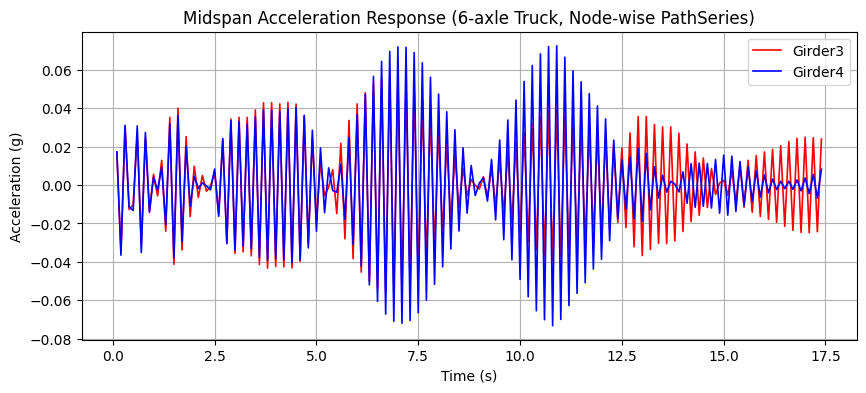

In [48]:
#Case9

E_girder1 = [28000] * girder_number * 2   # 21000 → 18000 (균열 고려 35% 감소)
E_deck1 =  [25000*0.7] * (girder_number + 1)  # 20000 → 17000 (균열 고려) 

## 바닥판 두께는 250, 30MPa로 가기
thickness1 =[250] * (girder_number + 2)  # 거더 + 캔틸레버 수 만큼 
thickness2 = [250] * (girder_number + 2)  # 거더 + 캔틸레버 수 만큼 

#A1 11, 10, 10, 10, 10, 10     x(교축), y(교축직각)
#A2 01, 00, 00, 00, 00, 00

# 순서는 교축, 교축직각, 수직  단위 kn/m
free = 0 #kn/m 단위
consts = 1e9/1e3  #kn/m 단위
consts1 = 80000  # 80000 → 35000 (kN/m)
consts_crack = 1e9/1e4
A1_B1 =  [free, consts1, consts, 0, 0, 0]
A1_B2 =  [free, consts1, consts, 0, 0, 0]
A1_B3 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B4 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B5 =  [free, consts1, consts_crack, 0, 0, 0]
A1_B6 =  [free, consts1, consts, 0, 0, 0]

A2_B1 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B2 =  [consts1, free, consts, 0, 0, 0]
A2_B3 =  [consts1, free, consts_crack, 0, 0, 0]   ## [kh, kh, kv, 0, 0, 0]  #[constraints, constraints, kv] 현재 코드에서는 입력조건과 관계없이 회전강성은 모두 0
A2_B4 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B5 =  [consts1, free, consts_crack, 0, 0, 0]
A2_B6 =  [consts1, consts1, consts, 0, 0, 0]


Bearing_Stiffness_A1 = np.vstack((A1_B1, A1_B2, A1_B3, A1_B4, A1_B5, A1_B6)) 
Bearing_Stiffness_A2 = np.vstack((A2_B1, A2_B2, A2_B3, A2_B4, A2_B5, A2_B6))

Bearing_Stiffness = np.vstack((Bearing_Stiffness_A1, Bearing_Stiffness_A2))

load_case_num = 1
load = -290*1000/2  #N 단위 (49ton트럭하중 재하)

PE = 600  # 350 → 200 MPa (장기손실 + 균열 + 이완 고려) 

diaphragm1_Ec =[24000]*5  # 열기준 배치 수 만큼 (거더 사이 = (거더수-1) )  # 열기준 배치 수 만큼 (거더 사이 = (거더수-1) )
diaphragm2_Ec = [24000]*5   # 가로보 
pave_thick = [80]

def find_indices_within_tol(array, values, tol=1e-3):
    idx_list = []
    for v in values:
        idx = np.where(np.abs(array - v) < tol)[0]
        if idx.size > 0:
            idx_list.append(idx[0])
    return np.array(idx_list)



build_bridge_model()
numEigen = 3
eigen_value = ops.eigen(numEigen)
print(eigen_value)
build_bridge_model()

# ------------------------------------------------------------
# 0️⃣ Geometry setup
# ------------------------------------------------------------
girder3 = ops.getNodeTags()[np.where(np.array(ops.getNodeTags()) == 3001)[0][0]:
                            np.where(np.array(ops.getNodeTags()) == 3001)[0][0] + 149]
girder4 = ops.getNodeTags()[np.where(np.array(ops.getNodeTags()) == 4001)[0][0]:
                            np.where(np.array(ops.getNodeTags()) == 4001)[0][0] + 149]

coords_g3 = np.array([ops.nodeCoord(nd) for nd in girder3])
coords_g4 = np.array([ops.nodeCoord(nd) for nd in girder4])
x_g3, y_g3 = coords_g3[:, 0], coords_g3[:, 1]
x_g4, y_g4 = coords_g4[:, 0], coords_g4[:, 1]
bridge_length = abs(x_g3[-1] - x_g3[0])

print(f"✅ Girder3: {len(girder3)} nodes, Girder4: {len(girder4)} nodes, Length = {bridge_length:.1f} mm")

# ------------------------------------------------------------
# 1️⃣ Vehicle configuration (6-axle truck)
# ------------------------------------------------------------
vehicle_config = {
    'loads': [61300.0/2, 114700.0/2, 110820.0/2,
              61300.0/2, 114700.0/2, 110820.0/2],  # [N]
    'distances': [0.0, 3300.0, 4600.0,
                  0.0, 3300.0, 4600.0]  # [mm]
}
velocity_kmh = 10
speed = velocity_kmh * 1000 * 1000 / 3600  # [mm/s]

x_start_g3, y_start_g3 = x_g3[-1], y_g3[-1]
x_start_g4, y_start_g4 = x_g4[-1], y_g4[-1]

dt = 0.1
truck_length = abs(max(vehicle_config['distances']))
t_total = (bridge_length + truck_length) / speed
time_steps = np.arange(0, t_total + 5, dt)

# ------------------------------------------------------------
# 2️⃣ Node-wise load history initialization
# ------------------------------------------------------------
node_load_history_g3 = {nd: np.zeros(len(time_steps)) for nd in girder3}
node_load_history_g4 = {nd: np.zeros(len(time_steps)) for nd in girder4}

def get_axle_positions(t):
    return [speed * t + d for d in vehicle_config['distances']]

# ------------------------------------------------------------
# 3️⃣ Load history generation
# ------------------------------------------------------------
for it, t in enumerate(time_steps):
    progress = speed * t

    for i_ax, (dist, load_val) in enumerate(zip(vehicle_config['distances'], vehicle_config['loads'])):
        if i_ax < 3:
            x_axle = x_start_g3 - progress + dist
            x_g, girder, node_hist = x_g3, girder3, node_load_history_g3
        else:
            x_axle = x_start_g4 - progress + dist
            x_g, girder, node_hist = x_g4, girder4, node_load_history_g4

        if x_g[0] <= x_axle <= x_g[-1]:
            idx = np.searchsorted(x_g, x_axle) - 1
            idx = np.clip(idx, 0, len(girder) - 2)
            xi, xj = x_g[idx], x_g[idx + 1]
            nd_i, nd_j = girder[idx], girder[idx + 1]
            r = (x_axle - xi) / (xj - xi)
            node_hist[nd_i][it] += load_val * (1 - r)
            node_hist[nd_j][it] += load_val * r

print("✅ Node-wise load histories generated for both girders.")

# ------------------------------------------------------------
# 4️⃣ Analysis setup
# ------------------------------------------------------------
ops.wipeAnalysis()

omega_list = np.sqrt(eigen_value)
omega1, omega2 = omega_list[0], omega_list[2]
zeta = 0.015 # damping value
alphaM = zeta * (2 * omega1 * omega2) / (omega1 + omega2)
betaK = 2 * zeta / (omega1 + omega2)
ops.rayleigh(alphaM, 0., 0., betaK)

ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('SparseGeneral')
ops.test('NormDispIncr', 1e-5, 10)
ops.algorithm('Newton')
ops.integrator('Newmark', 0.5, 0.25)
ops.analysis('Transient')


# ------------------------------------------------------------
# 5️⃣ Recorders
# ------------------------------------------------------------
mid_node_g3 = girder3[len(girder3)//2]
mid_node_g4 = girder4[len(girder4)//2]
g3_text = '(case9)mid_accel_g3.csv'
g4_text = '(case9)mid_accel_g4.csv'

ops.recorder('Node', '-file', g3_text, '-time', '-node', mid_node_g3, '-dof', 3, 'accel')
ops.recorder('Node', '-file', g4_text, '-time', '-node', mid_node_g4, '-dof', 3, 'accel')

# ------------------------------------------------------------
# 6️⃣ Create PathSeries (노드별, girder별 오프셋 적용)
# ------------------------------------------------------------
def create_pathseries_from_history(history_dict, girder_id):
    for nd in history_dict:
        values = history_dict[nd]
        if np.allclose(values, 0.0):
            continue
        ts_tag = 1000 * girder_id + nd
        pat_tag = 2000 * girder_id + nd
        ops.timeSeries('Path', ts_tag, '-dt', dt, '-values', *values.tolist(), '-factor', 1.0)
        ops.pattern('Plain', pat_tag, ts_tag)
        ops.load(nd, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0)

create_pathseries_from_history(node_load_history_g3, 3)
create_pathseries_from_history(node_load_history_g4, 4)
print("✅ PathSeries created (node-wise, unique tags).")

# ------------------------------------------------------------
# 7️⃣ Run analysis
# ------------------------------------------------------------
ops.analyze(len(time_steps), dt)
print("✅ Analysis completed.")

# ------------------------------------------------------------
# 8️⃣ Plot results
# ------------------------------------------------------------
data_g3 = np.loadtxt(g3_text)
data_g4 = np.loadtxt(g4_text)

t = data_g3[:, 0]
acc_g3 = data_g3[:, 1] / 9.81 / 1000
acc_g4 = data_g4[:, 1] / 9.81 / 1000

plt.figure(figsize=(10, 4))
plt.plot(t, acc_g3, 'r-', lw=1.2, label='Girder3')
plt.plot(t, acc_g4, 'b-', lw=1.2, label='Girder4')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Midspan Acceleration Response (6-axle Truck, Node-wise PathSeries)')
plt.legend()
plt.grid(True)
plt.show()